In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#oiv2 ds
filePath = '/Users/a_rust/Documents/EV353_Oceanography/soda_sss_1980-2024.nc'
soda = xr.open_dataset(filePath)
soda_sss = soda['salt']
soda_sss

<xarray.DataArray 'salt' (time: 540, yt_ocean: 364, xt_ocean: 808)>
[158820480 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 0.25 0.75 0.75 1.25 ... 358.2 358.8 359.2 359.8
  * yt_ocean  (yt_ocean) float64 -74.75 -74.25 -73.75 ... 88.75 89.25 89.75
  * time      (time) datetime64[ns] 1980-01-16T01:00:00 ... 2024-12-02T13:00:00
    st_ocean  float64 ...
Attributes:
    standard_name:  sea_water_salinity
    long_name:      Practical Salinity
    units:          psu
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [3]:
#soda ds
filePath = '/Users/a_rust/Documents/EV353_Oceanography/oiv2.nc'
oiv2 = xr.open_dataset(filePath)
sst = oiv2['sst']
sst 

<xarray.DataArray 'sst' (time: 492, lat: 180, lon: 360)>
[31881600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-12-01
Attributes: (12/13)
    long_name:             Monthly Mean of Sea Surface Temperature
    unpacked_valid_range:  [-5. 40.]
    actual_range:          [-1.7999996 35.56862  ]
    units:                 degC
    precision:             2
    var_desc:              Sea Surface Temperature
    ...                    ...
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Weekly Mean
    standard_name:         sea_surface_temperature
    cell_methods:          time: mean (monthly from weekly values interpolate...
    valid_range:           [-500 4000]

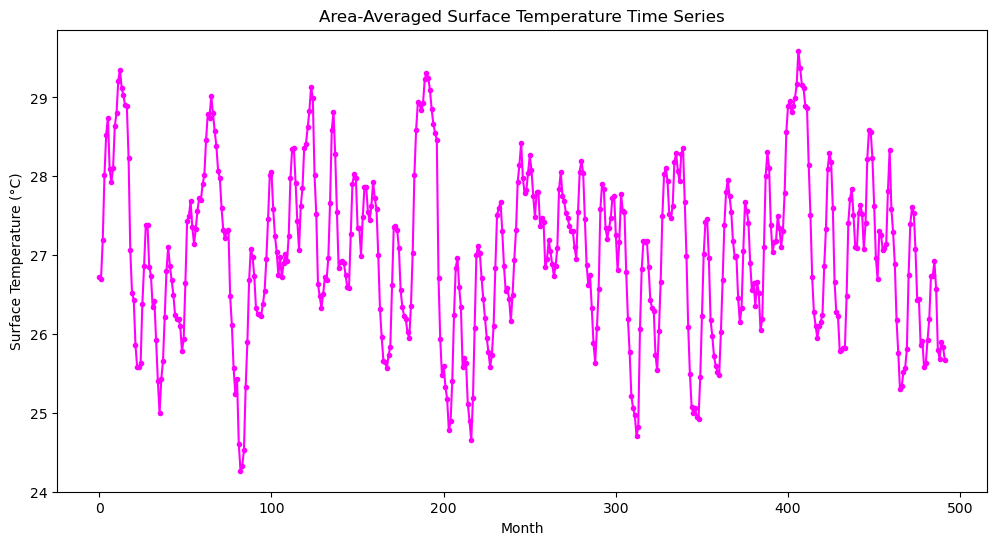

<xarray.DataArray 'time' (time: 492)>
array(['1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1982-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-12-01
Attributes:
    long_name:        Time
    actual_range:     [66443. 81449.]
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    bounds:           time_bnds

In [4]:
nino34 = sst.where((sst.lat >= -5) &
                      (sst.lat <= 5) &
                      (sst.lon >= 190) &
                      (sst.lon <= 240), drop='TRUE')

# nino area-averaged surface temp (st)
nino34 = nino34.mean(dim=['lat', 'lon'])

#plot time series for surface temp 
plt.figure(figsize=(12,6))
plt.plot(nino34, marker = '.', color = 'magenta', linestyle='solid', label='Area-Averaged SST')
plt.xlabel('Month')
plt.ylabel('Surface Temperature (°C)')
plt.title('Area-Averaged Surface Temperature Time Series')
plt.show()

nino34['time']

In [5]:
climnino = nino34.groupby("time.month").mean()

#plot anomolies
anom = nino34.groupby("time.month") - climnino
anom

#std of anom
sd= anom.std()
sd

# group by DJF
seasonal_data = anom.resample(time='QS-DEC').mean()
DJF = seasonal_data.sel(time =(seasonal_data['time.month'] ==12)).groupby('time.year').mean()

#defining el nino events for Hosing
nino_events = DJF.where(DJF > sd, drop = True)
nino_events

#calculate monthly anamolies for every model grid point ##step 6!!
sst_clim = sst.groupby(sst["time.month"]).mean()
sst_clim

sst_anom = sst.groupby(sst["time.month"]) - sst_clim
sst_anom

# make a DJF seasonal avg. timeseries for every grid point #step 7!!
seasonal_sst_data = sst_anom.resample(time='QS-DEC').mean()
seasonal_sst_data

sst_DJF = seasonal_sst_data.sel(time =(seasonal_data['time.month'] ==12)).groupby('time.year').mean()
sst_DJF

#Identify el nino events
nino_events = DJF > sd

#index of Nino events
idx_nino_events = [i for i, x in enumerate(nino_events) if x]
idx_nino_events

[1, 5, 10, 13, 16, 21, 28, 34]

In [ ]:
('Year' + f'{str(i)}') 

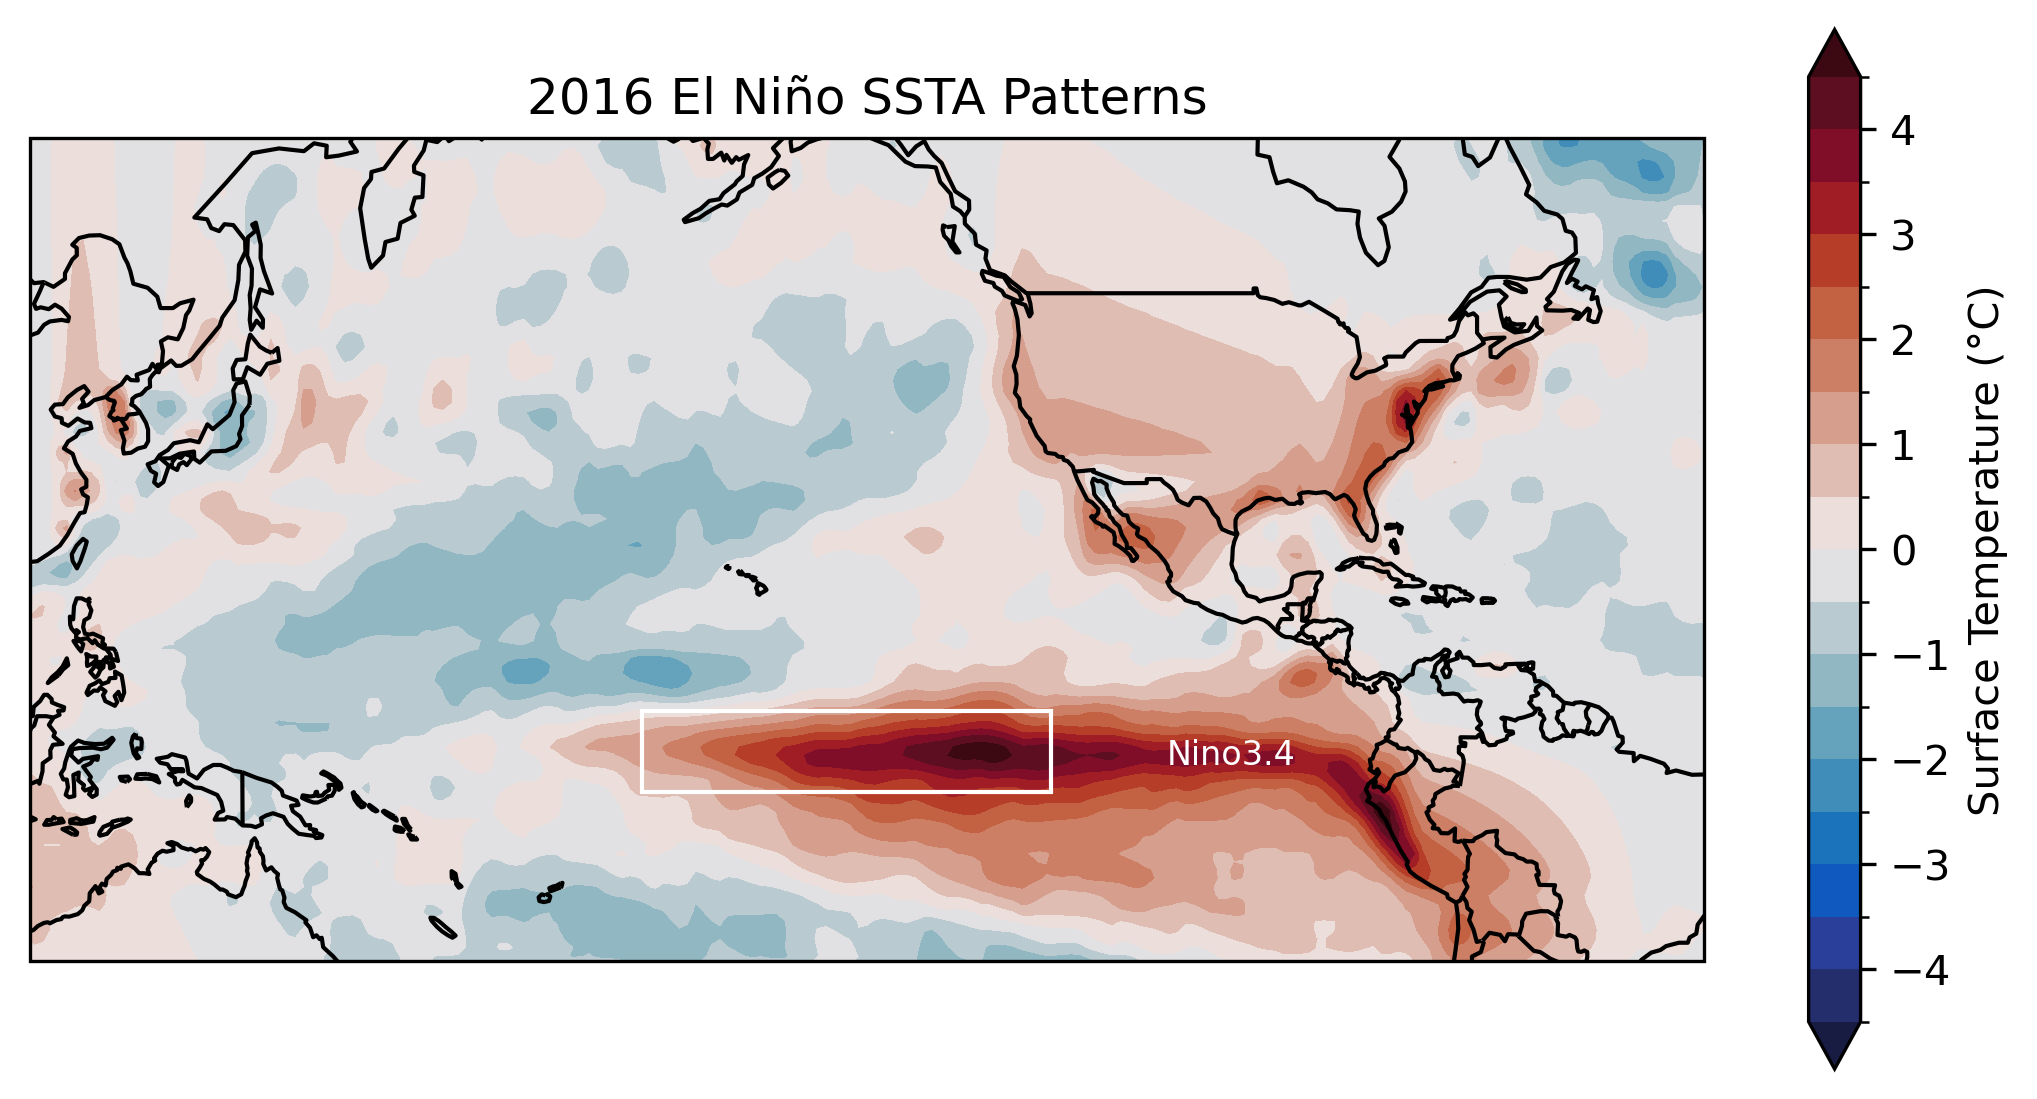

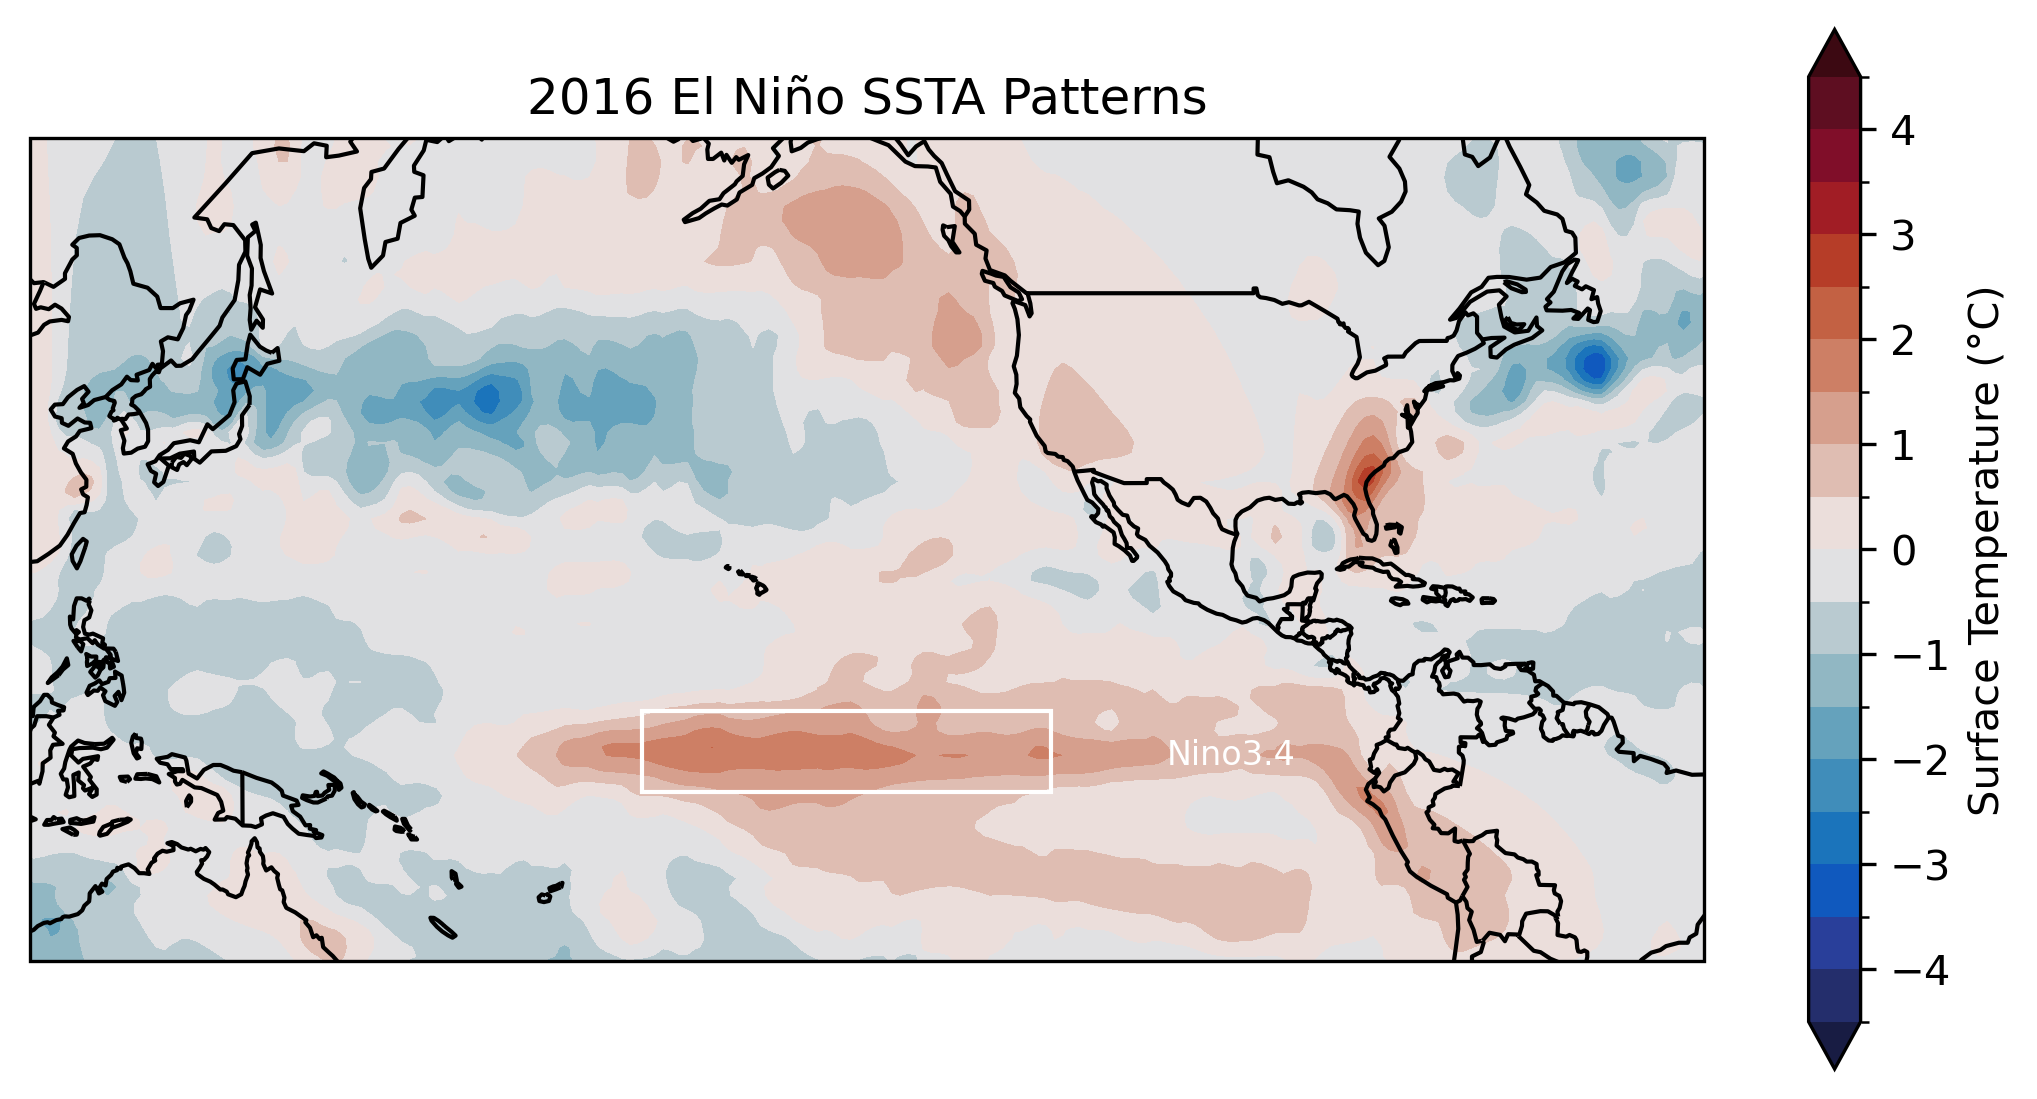

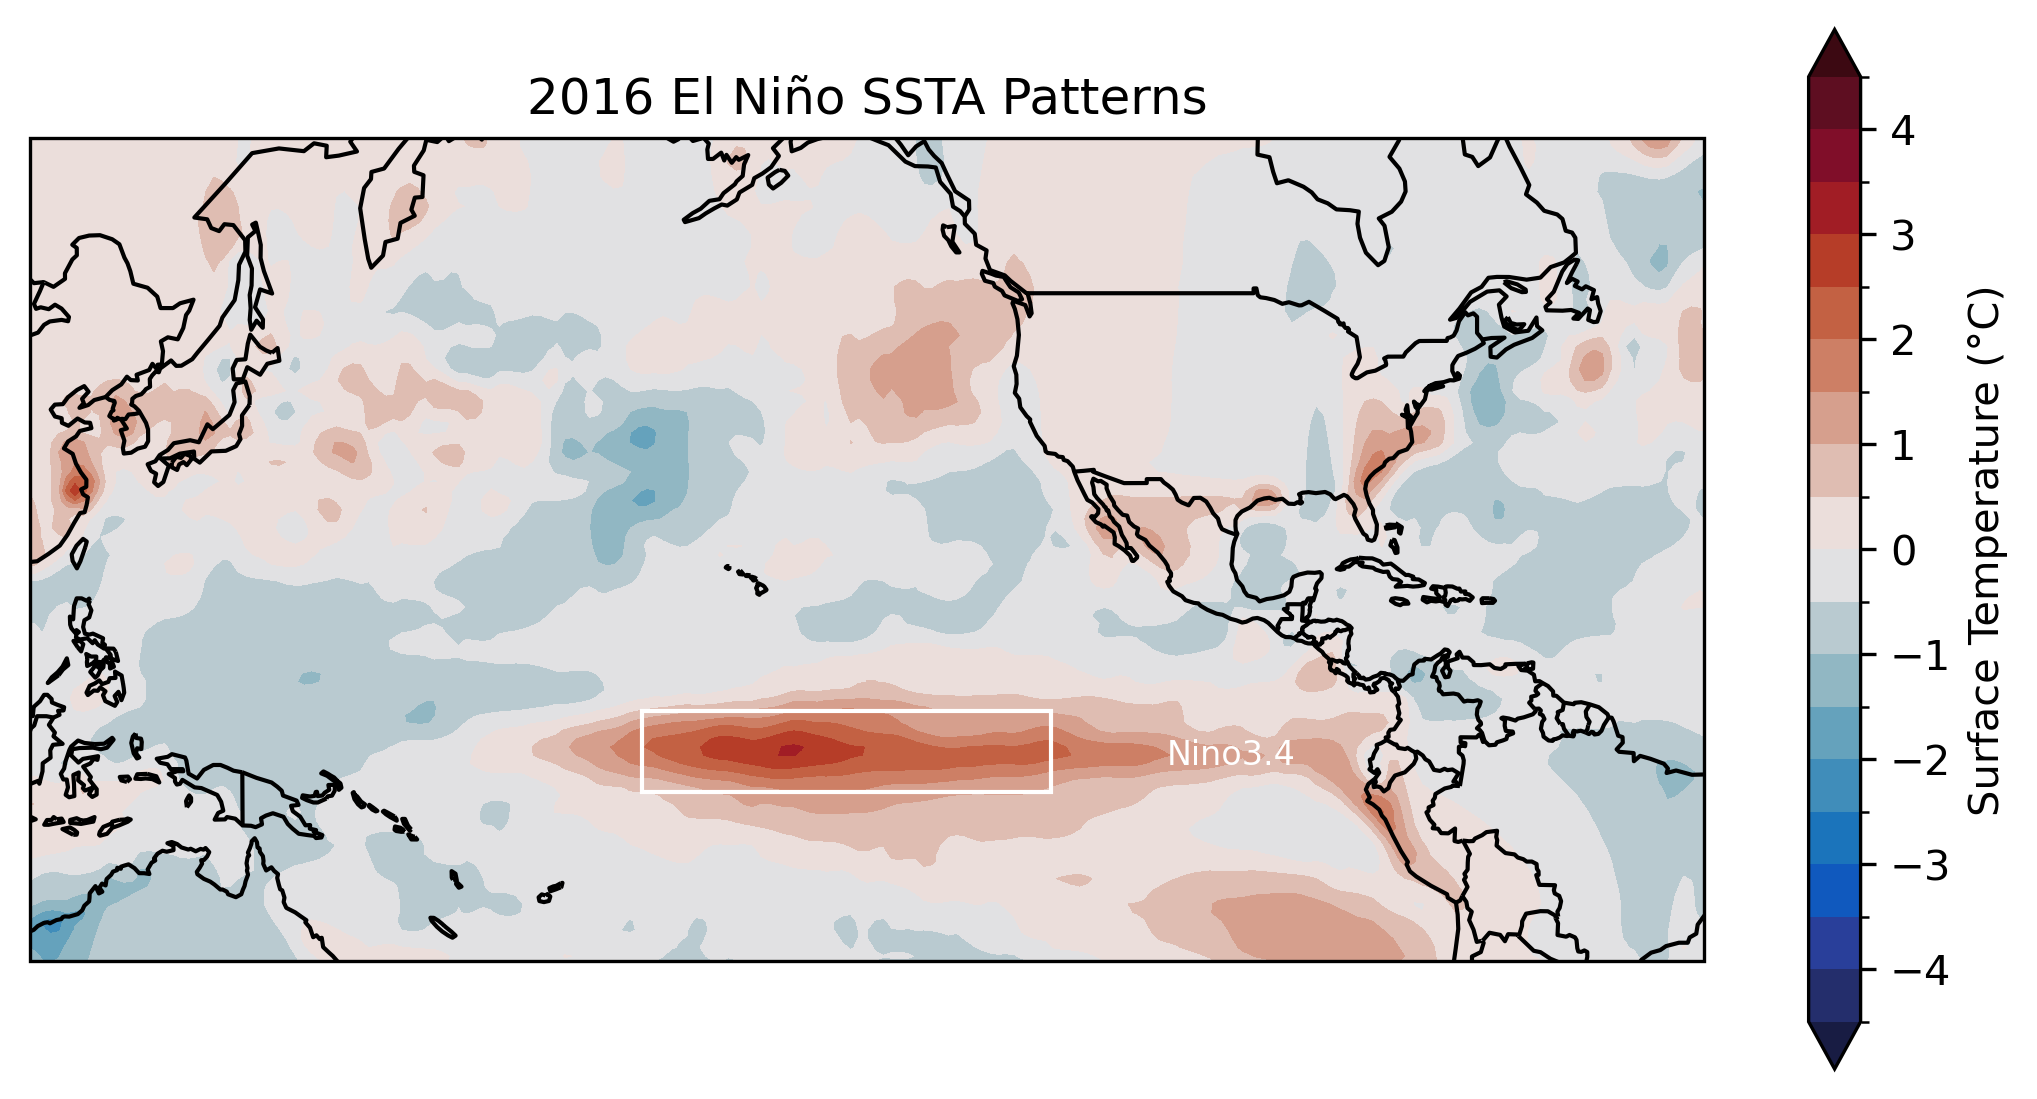

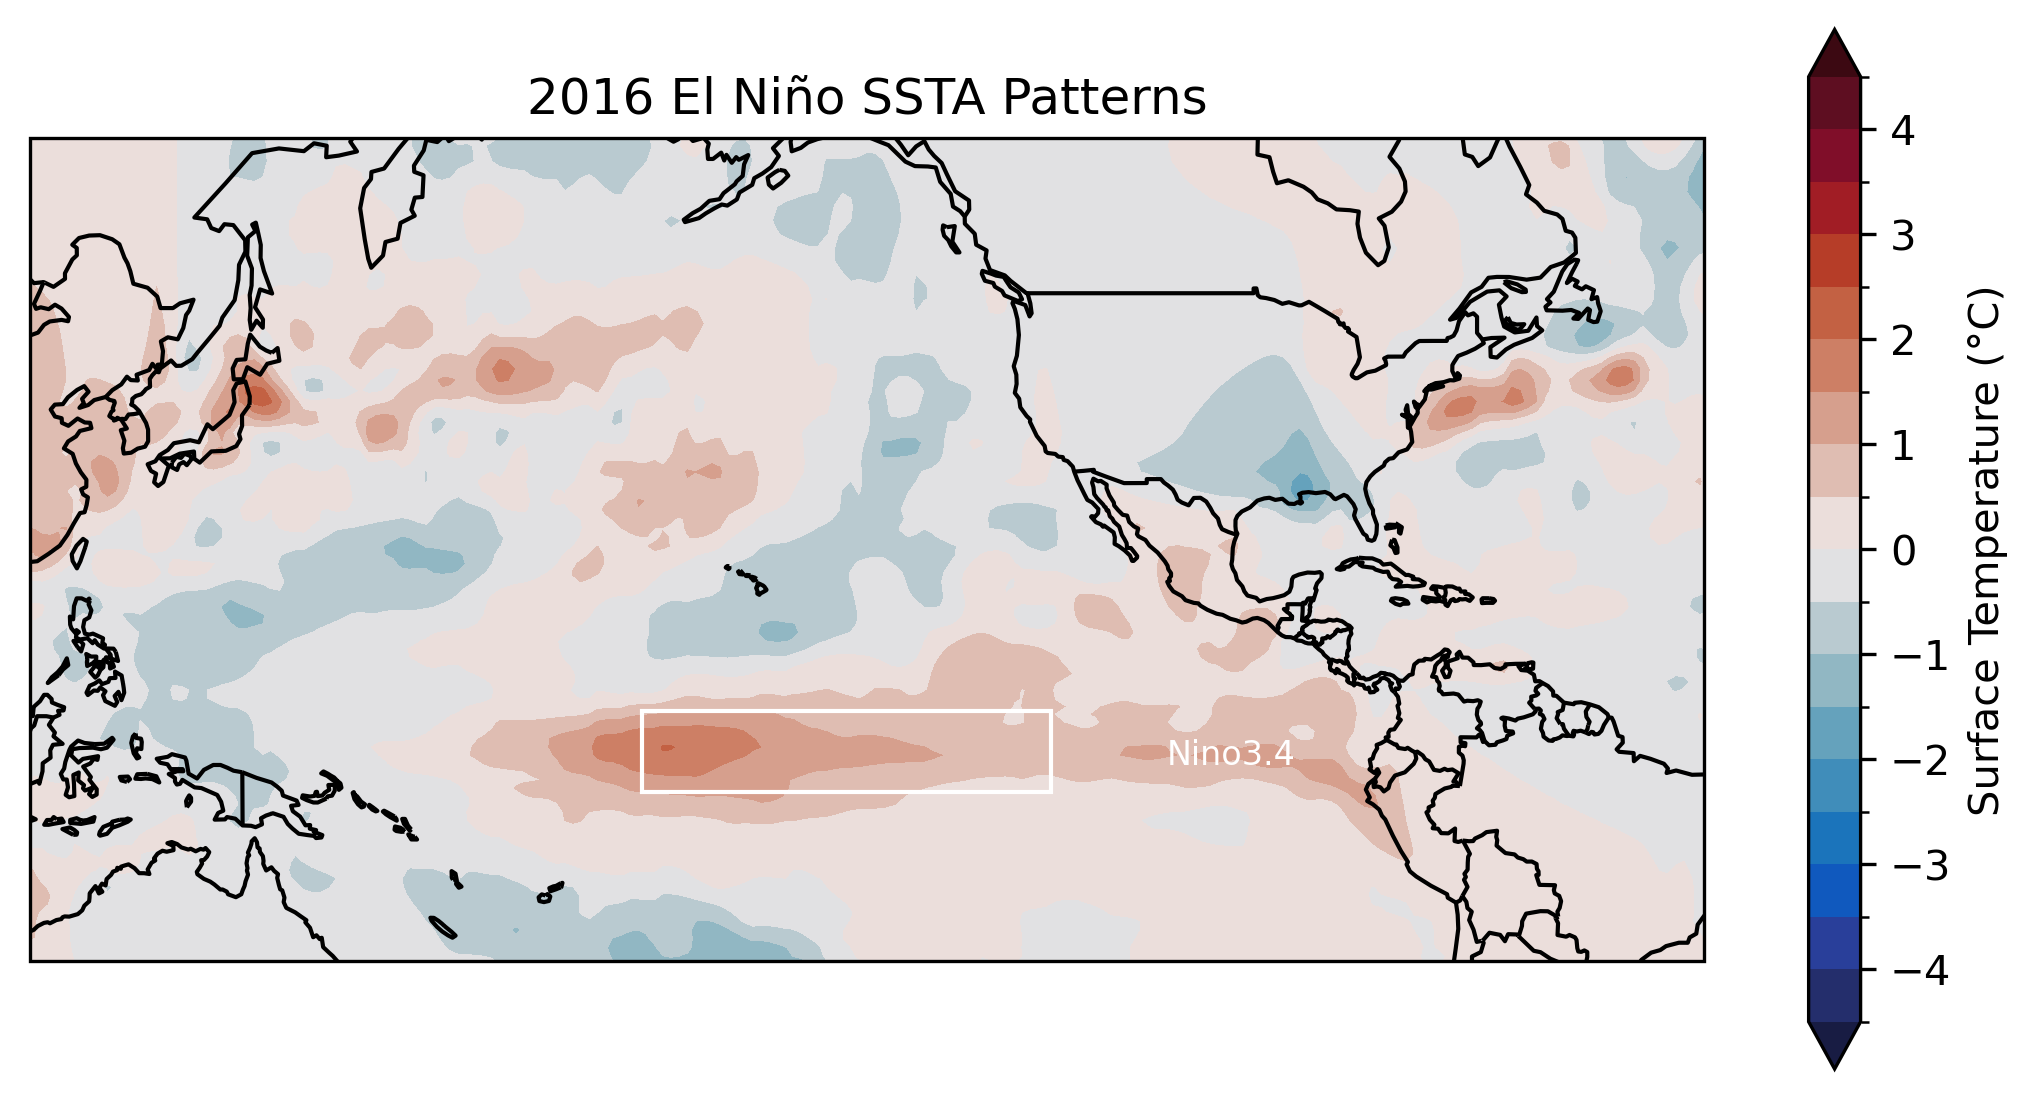

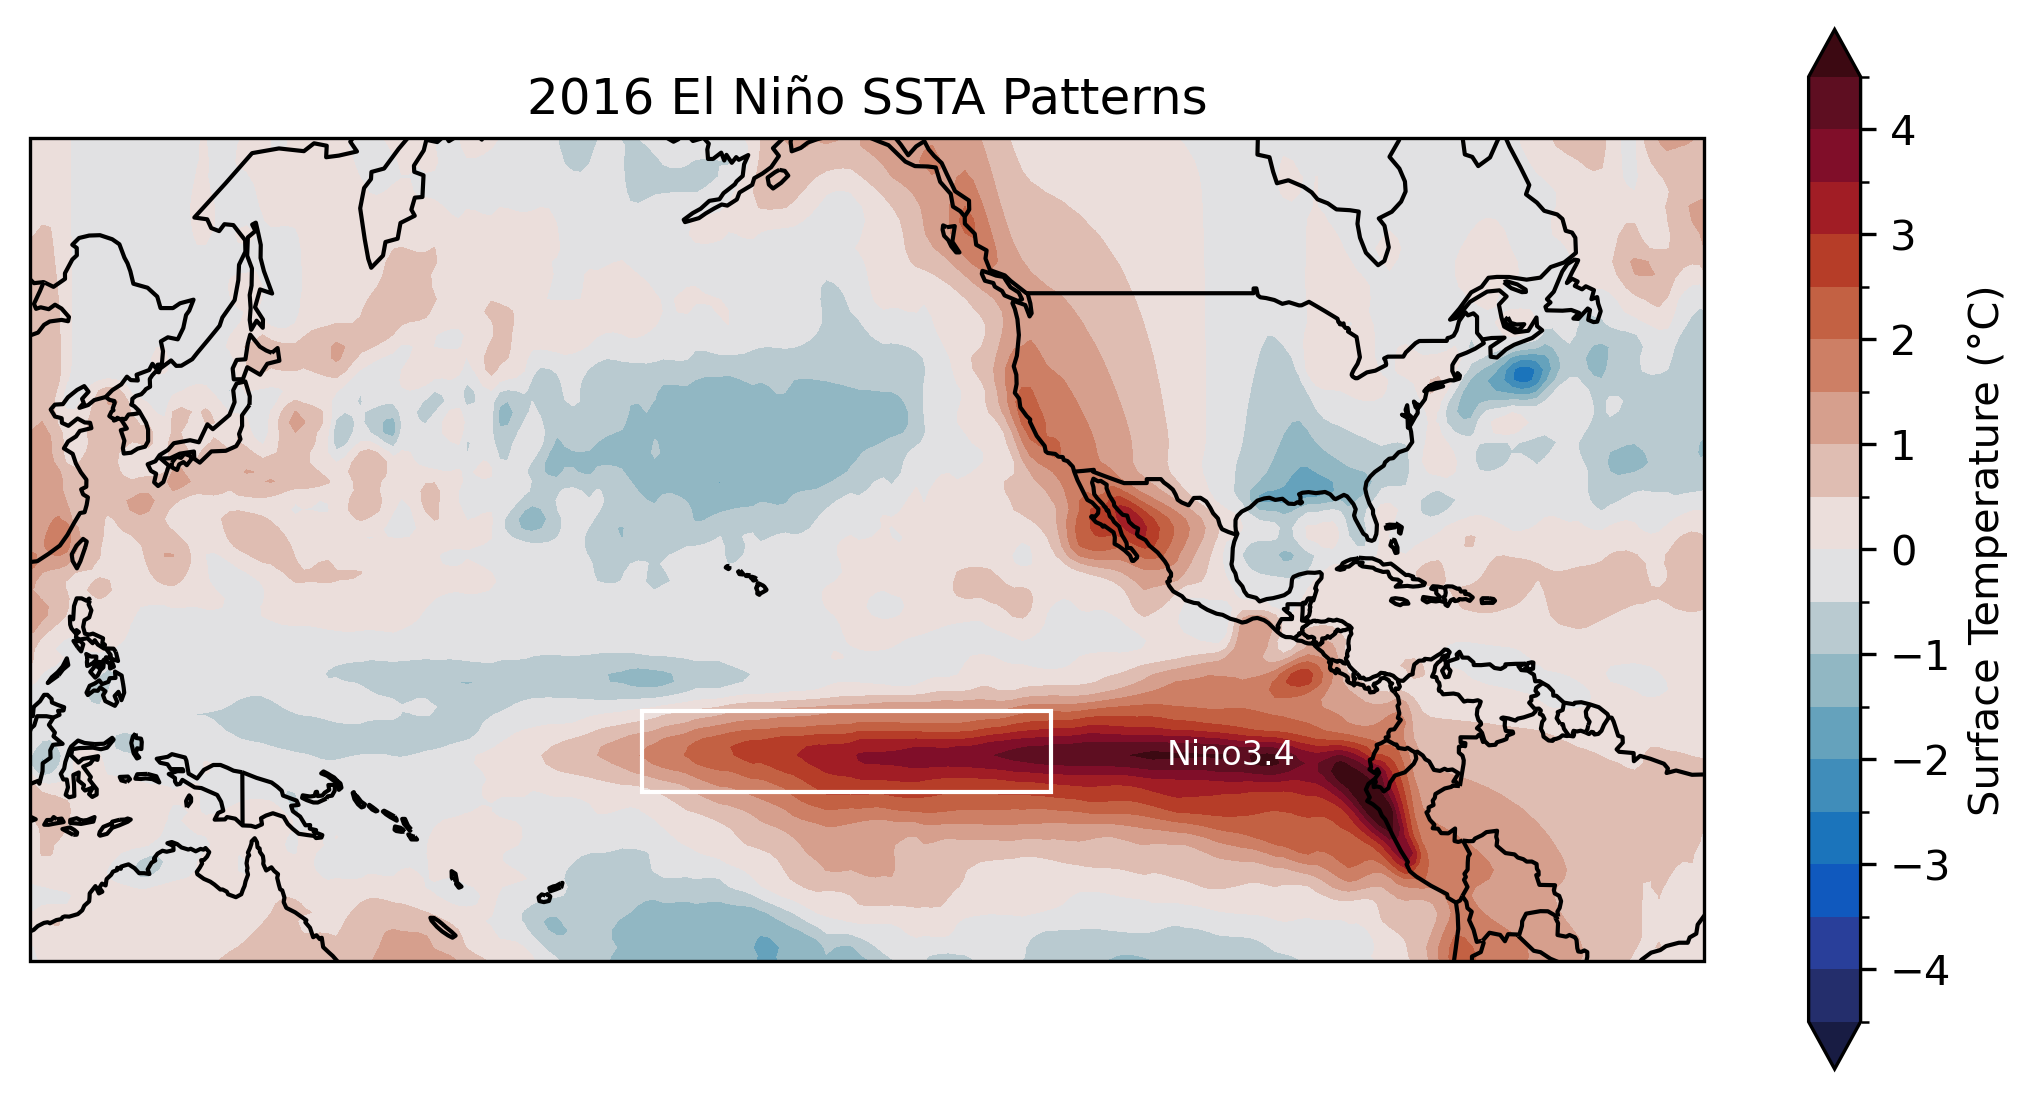

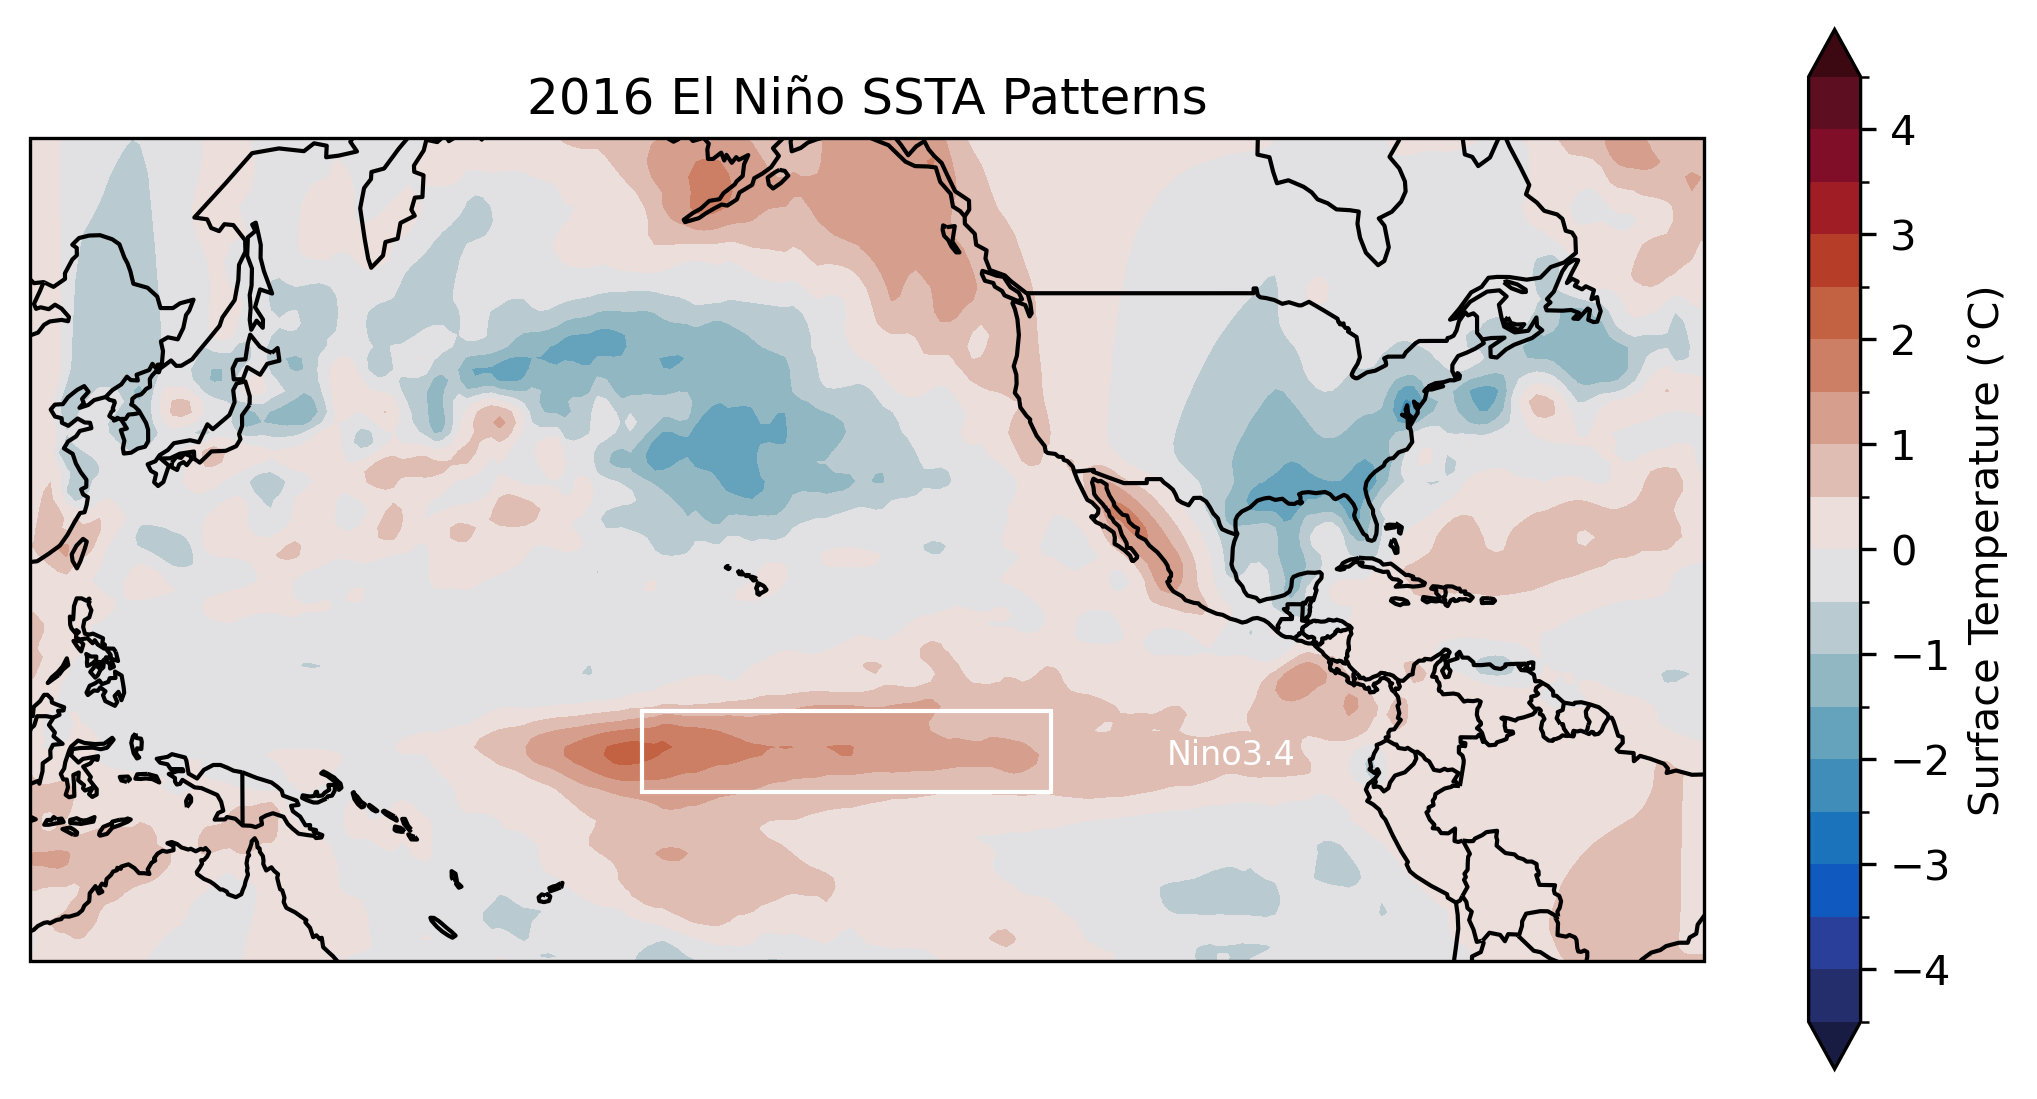

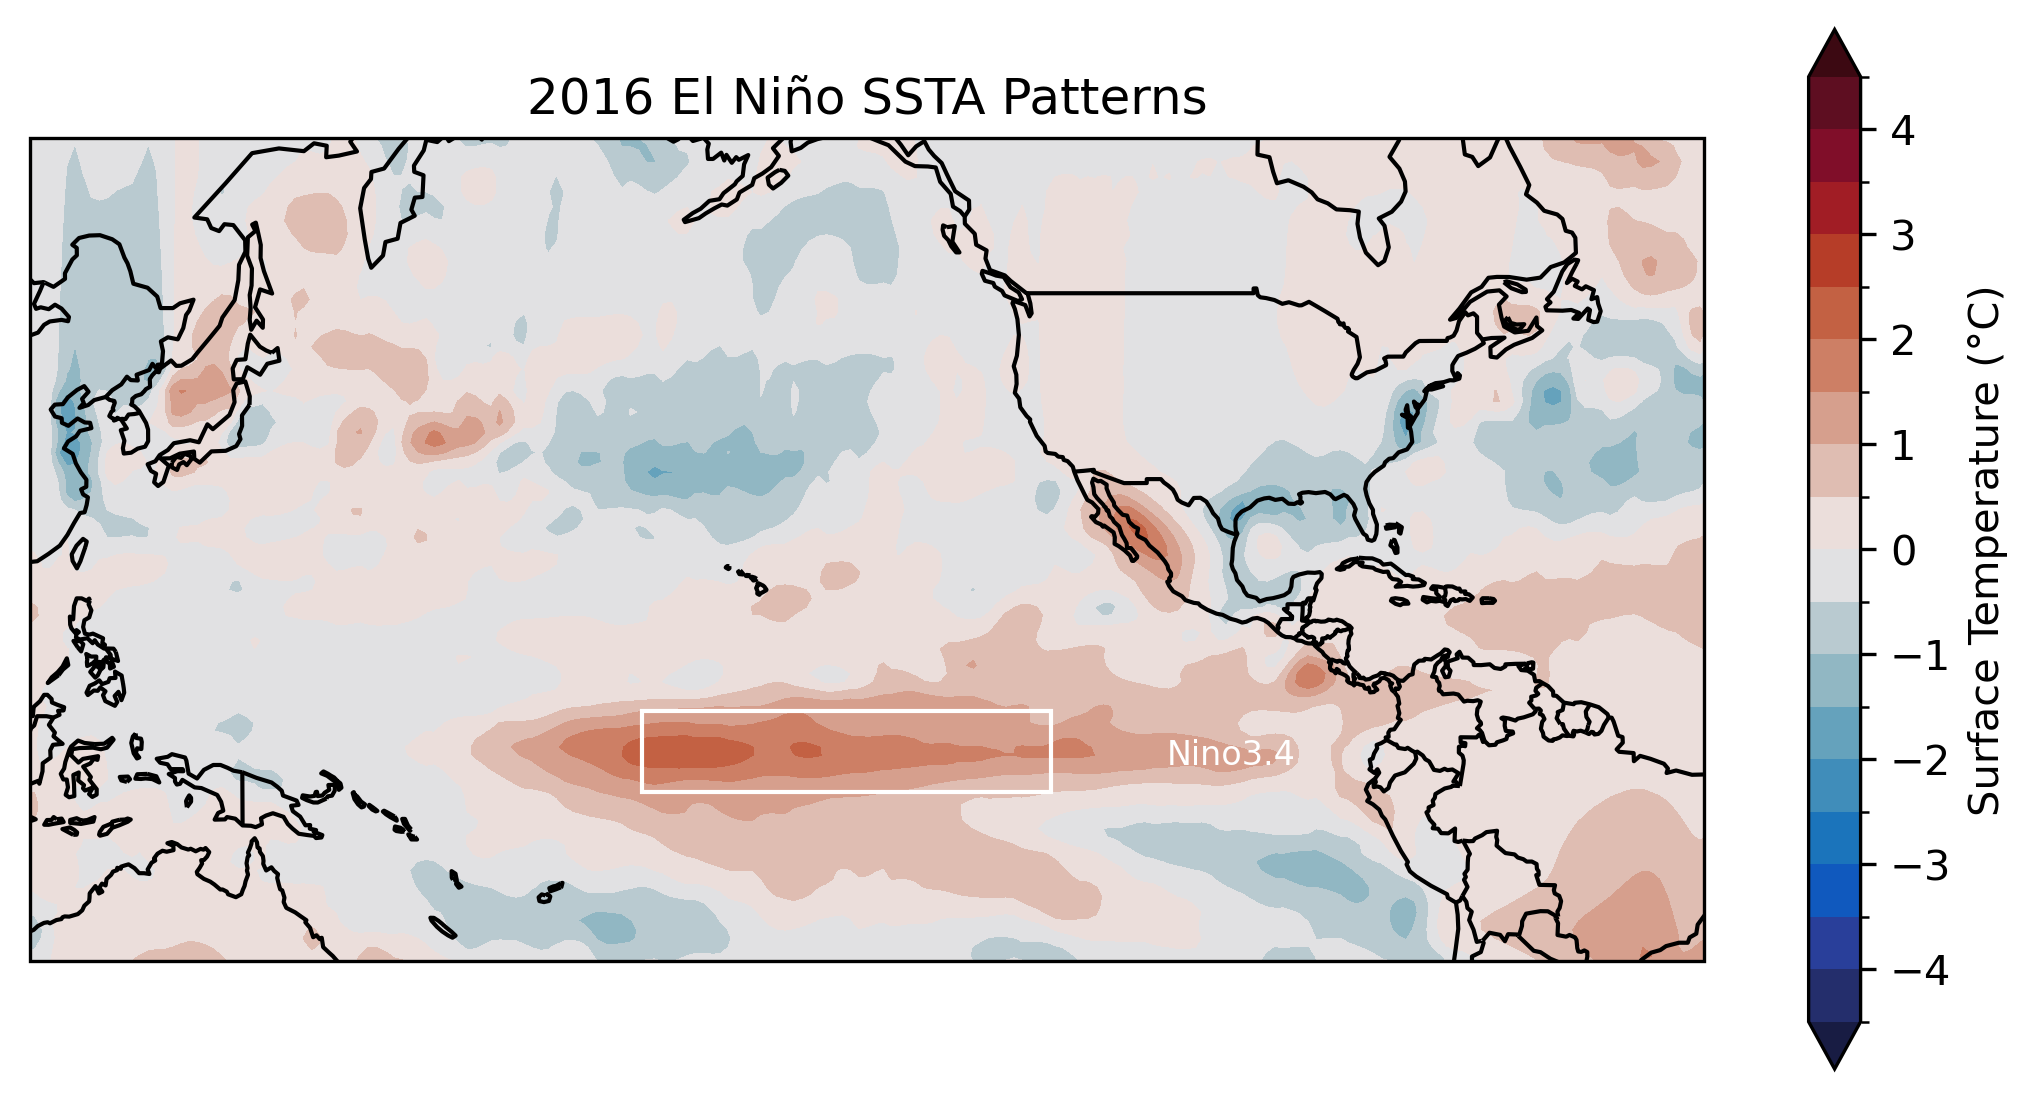

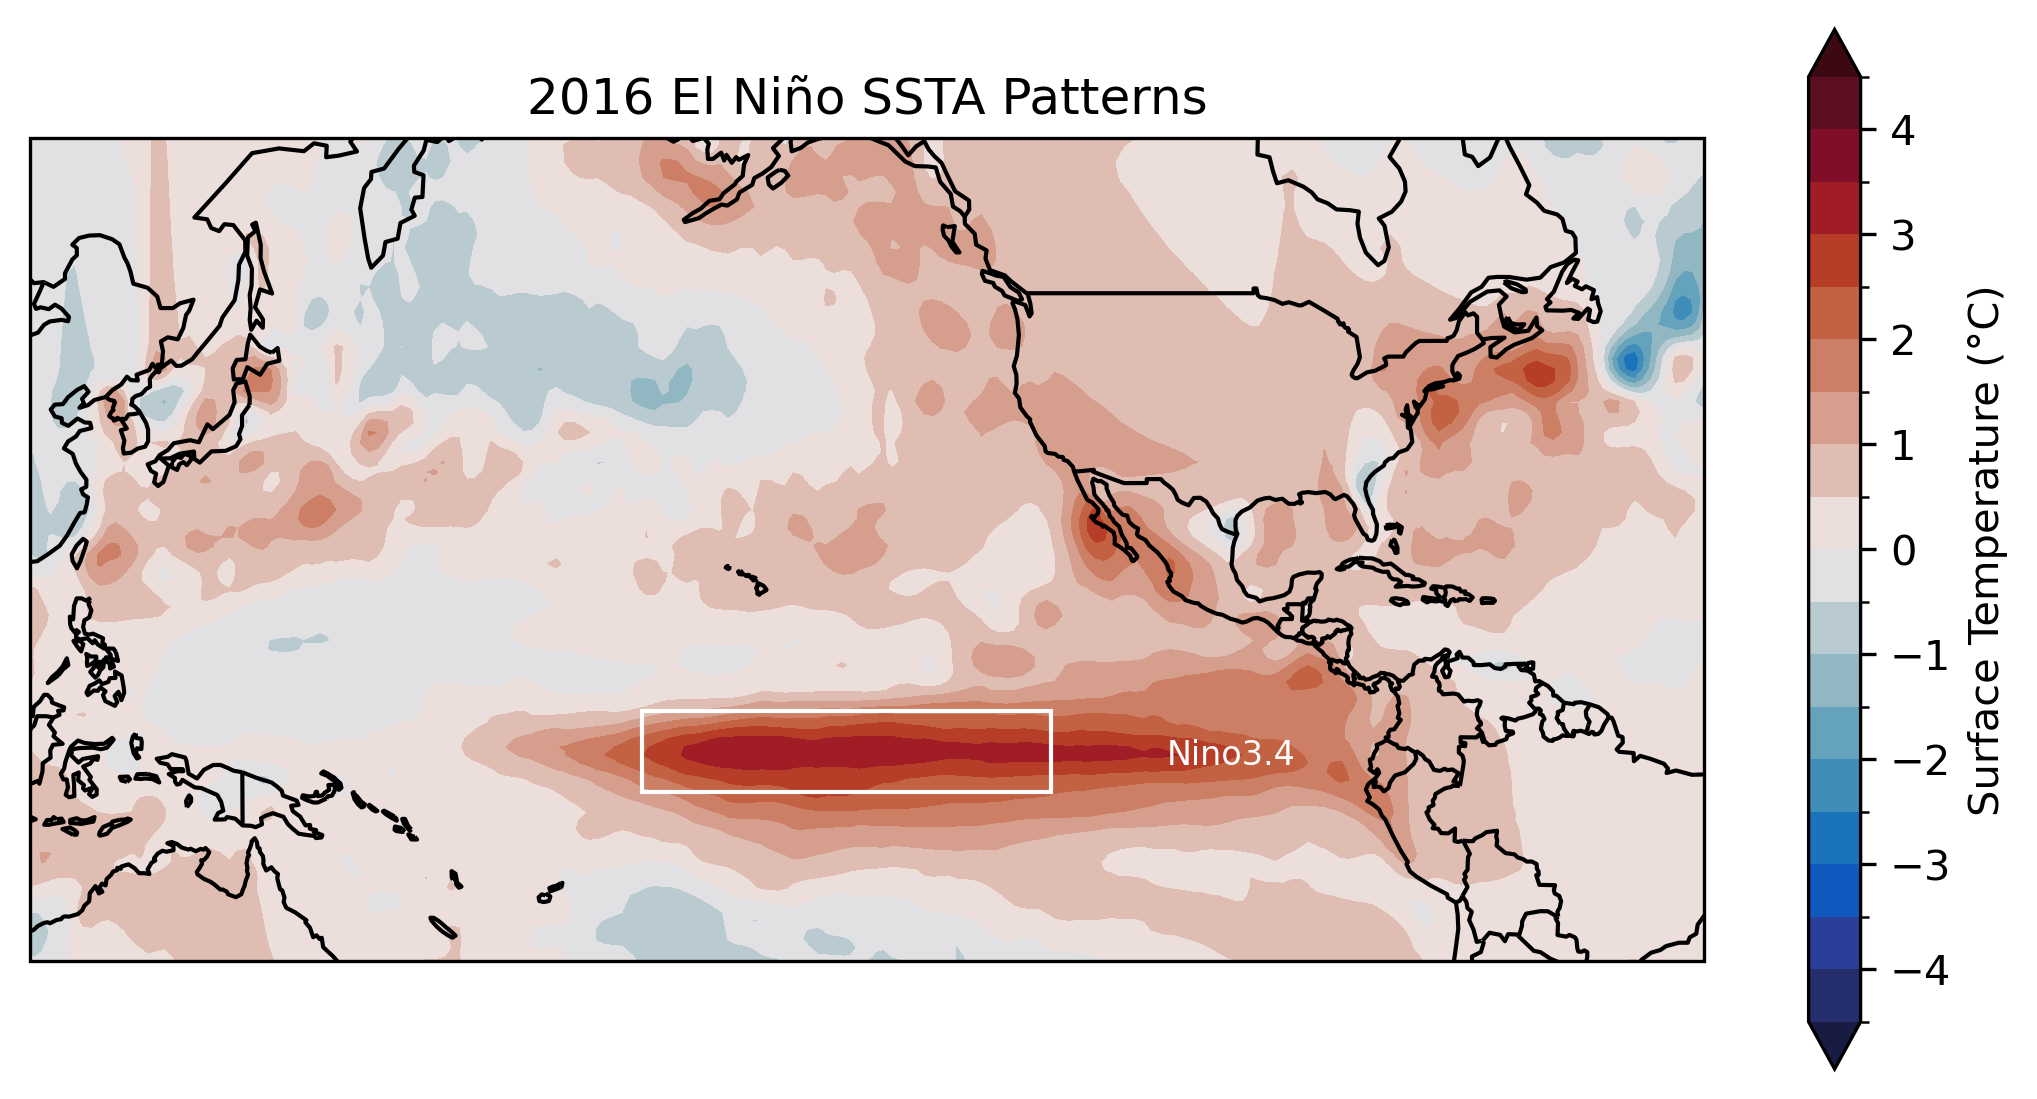

In [39]:
for i in idx_nino_events:

    #data for selected nino event
    anom_tmp = sst_DJF[i]
    
    proj = ccrs.Mercator(central_longitude=270)
    cmap = cmocean.cm.balance
    
    lev = np.arange(-4.5, 4.55, 0.5)
    fig = plt.figure(figsize=(9, 4.5), dpi=300)
    ax = plt.axes(projection = proj)
    
    anom_tmp.plot.contourf(
        x='lon',
        y='lat',
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=lev,
        extend='both',
        cmap=cmap,
        cbar_kwargs={'label': 'Surface Temperature (°C)', 'orientation': 'vertical', 'pad': 0.05},)
     
    # add coastlines
    ax.add_feature(cfeature.BORDERS, linestyle ='None')
    ax.coastlines(resolution='110m')  
     
    # add title
    ax.set_title('2016 El Niño SSTA Patterns') 
    #define area 
    ax.set_extent([115,320,-25,60], crs=ccrs.PlateCarree())
    
    #add nino3.4 rectangle region
    rectangle = plt.Rectangle(
        xy=(-170, -5),
        width=50,
        height=10,
        linewidth=1,
        edgecolor='white',
        facecolor='none',
        transform=ccrs.PlateCarree())
    ax.add_patch(rectangle)
    
    #add a title to the rectangle
    ax.annotate('Nino3.4', xy=(-170, -5), xytext=(-170, -5),
                color='white', fontsize=8, ha='right', va='center_baseline',)
    
    # save figure
    title = f"A_{str(i)}_ST"
    fig.savefig(f'_{title}.png', facecolor='white', transparent=False, bbox_inches='tight')


In [7]:
#Salinity
filepath = '/Users/a_rust/Documents/EV353_Oceanography/mld.nc'
mld = xr.open_dataset(filepath)
salinity = mld['mld_DR'].mean(dim='time')
salinity

<xarray.DataArray 'mld_DR' (lat: 90, lon: 180)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [101.77682 , 101.85876 , 101.797905, ..., 101.58227 , 102.21003 ,
        101.96798 ],
       [ 40.240204,  40.222248,  40.11399 , ...,  40.15909 ,  40.16412 ,
         39.852486],
       [ 27.376825,  26.843039,  26.828337, ...,  27.43217 ,  27.413597,
         27.395178]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 84.0 86.0 88.0 89.5
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [8]:
sst_anom

<xarray.DataArray 'sst' (time: 492, lat: 180, lon: 360)>
array([[[ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 3.4148693e-03,  7.3194504e-04,  2.4402142e-04, ...,
         -7.3111057e-04, -7.3111057e-04, -9.7501278e-04],
        ...,
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07]],

       [[ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [-3.9020777e-03, -5.6093931e-03, -5.8531761e-03, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
...
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07]],

       [[ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [-7.0729256e-03, -8.0486536e-03, -9.0242624e-03, ...,
         -1.4628172e-03, -1.4628172e-03, -1.7069578e-03],
        ...,
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07],
        [ 7.1525574e-07,  7.1525574e-07,  7.1525574e-07, ...,
          7.1525574e-07,  7.1525574e-07,  7.1525574e-07]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

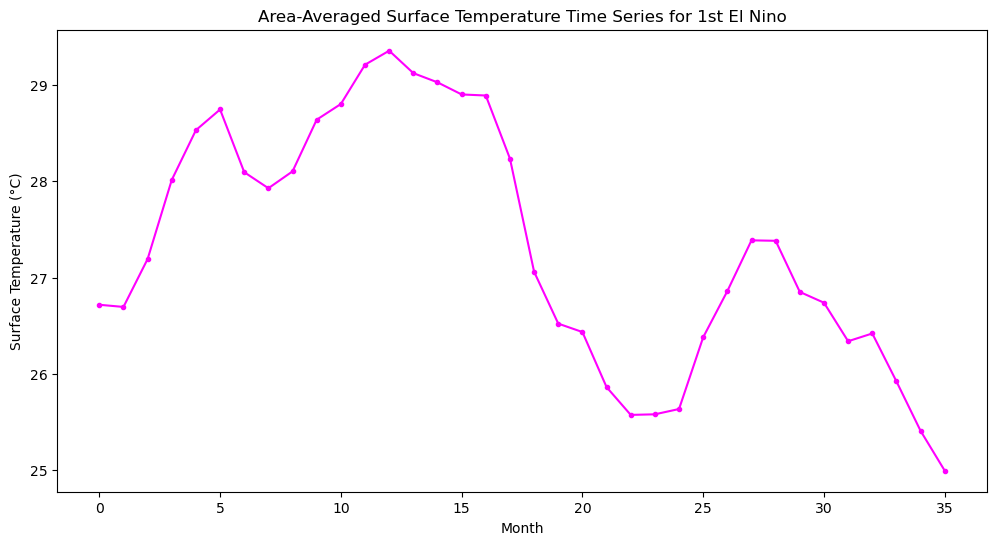

In [9]:
#SST for each El Nino
elnino1 = oiv2['sst']
elnino1 = elnino1.sel(time= slice('1982.00', '1984.00'))

elnino1 = elnino1.where((elnino1.lat >= -5) &
                      (elnino1.lat <= 5) &
                      (elnino1.lon >= 190) &
                      (elnino1.lon <= 240), drop='TRUE')

# nino area-averaged surface temp (st)
elnino1 = elnino1.mean(dim=['lat', 'lon'])

#plot time series for surface temp 
plt.figure(figsize=(12,6))
plt.plot(elnino1, marker = '.', color = 'magenta', linestyle='solid', label='Area-Averaged SST')
plt.xlabel('Month')
plt.ylabel('Surface Temperature (°C)')
plt.title('Area-Averaged Surface Temperature Time Series for 1st El Nino')
plt.show()

In [10]:
#---do not modify---
def detrend(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

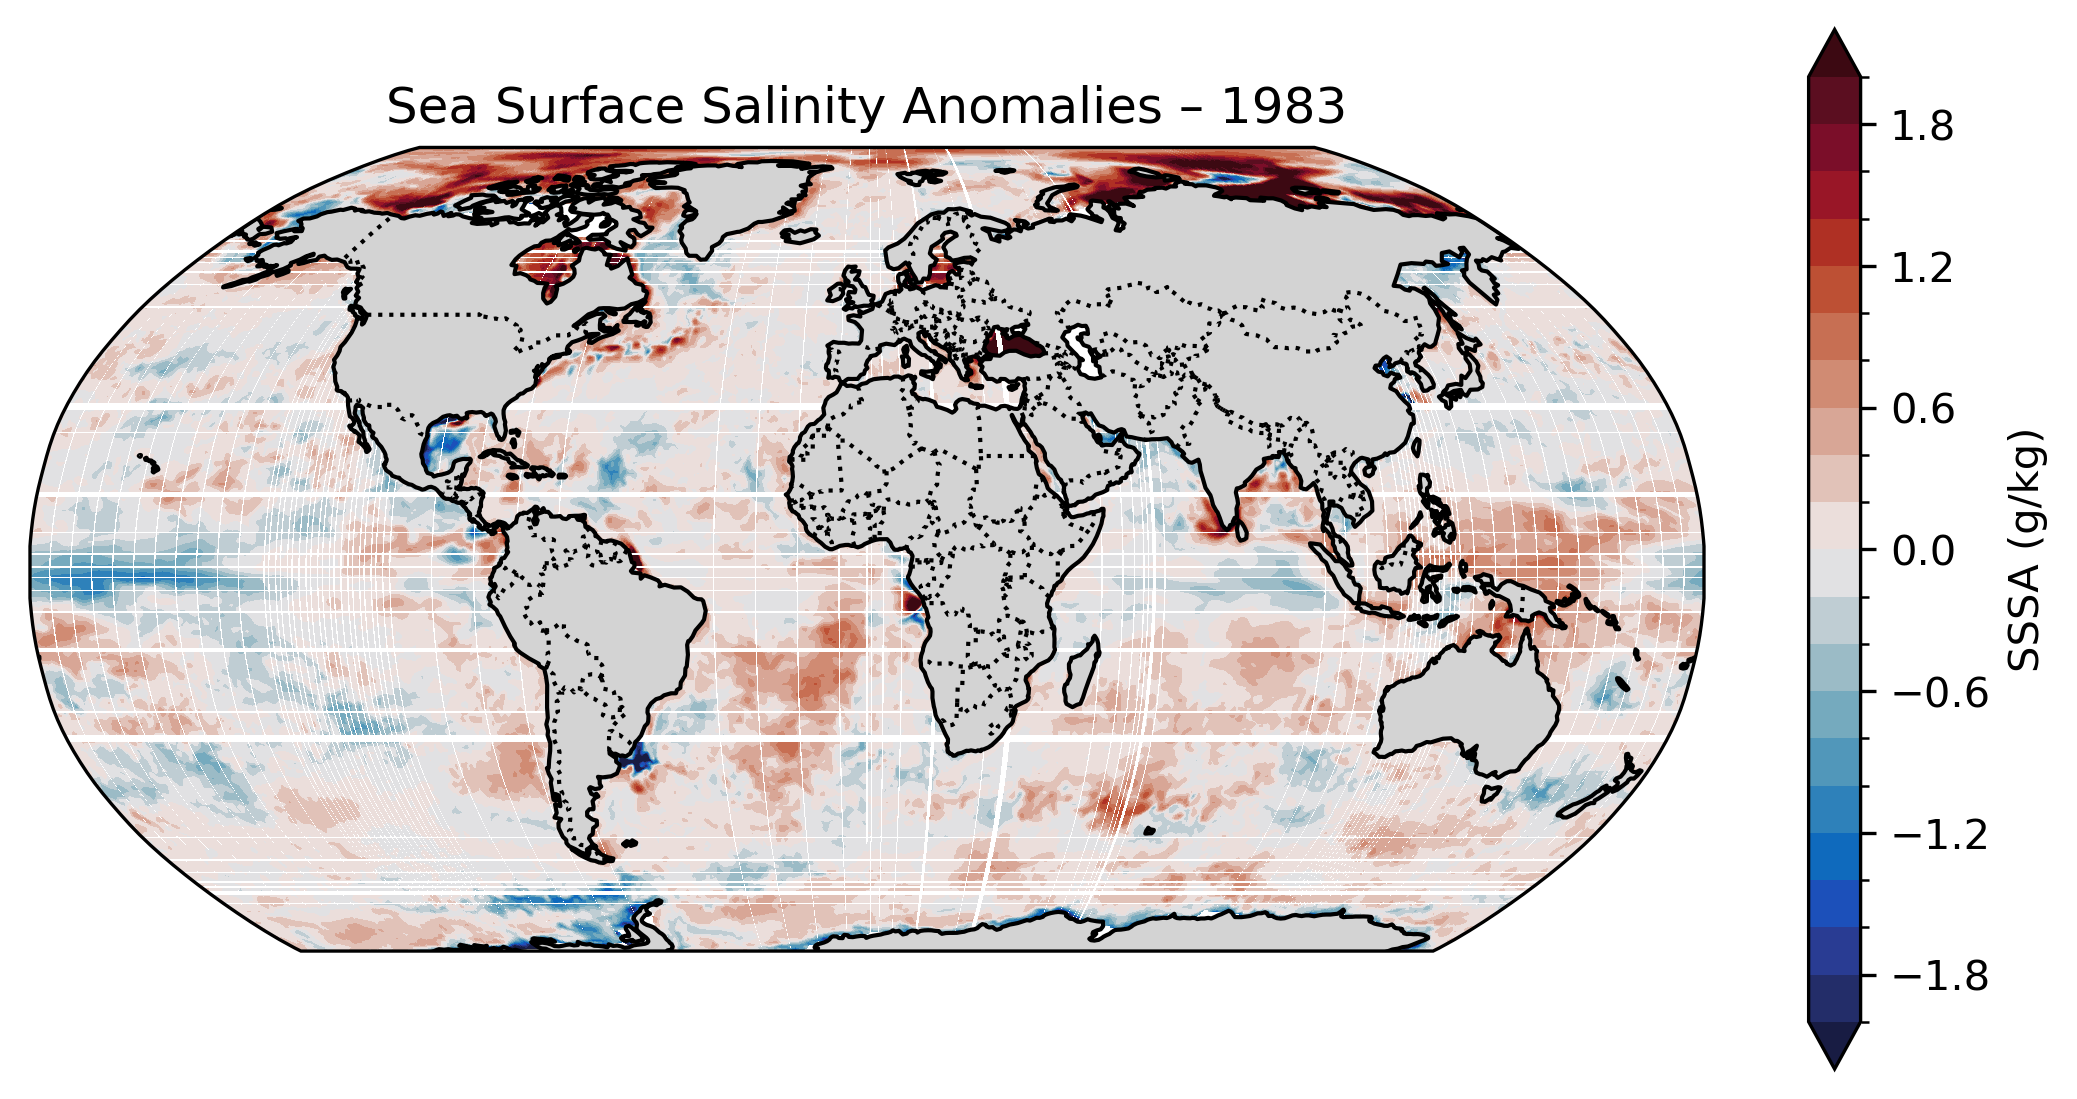

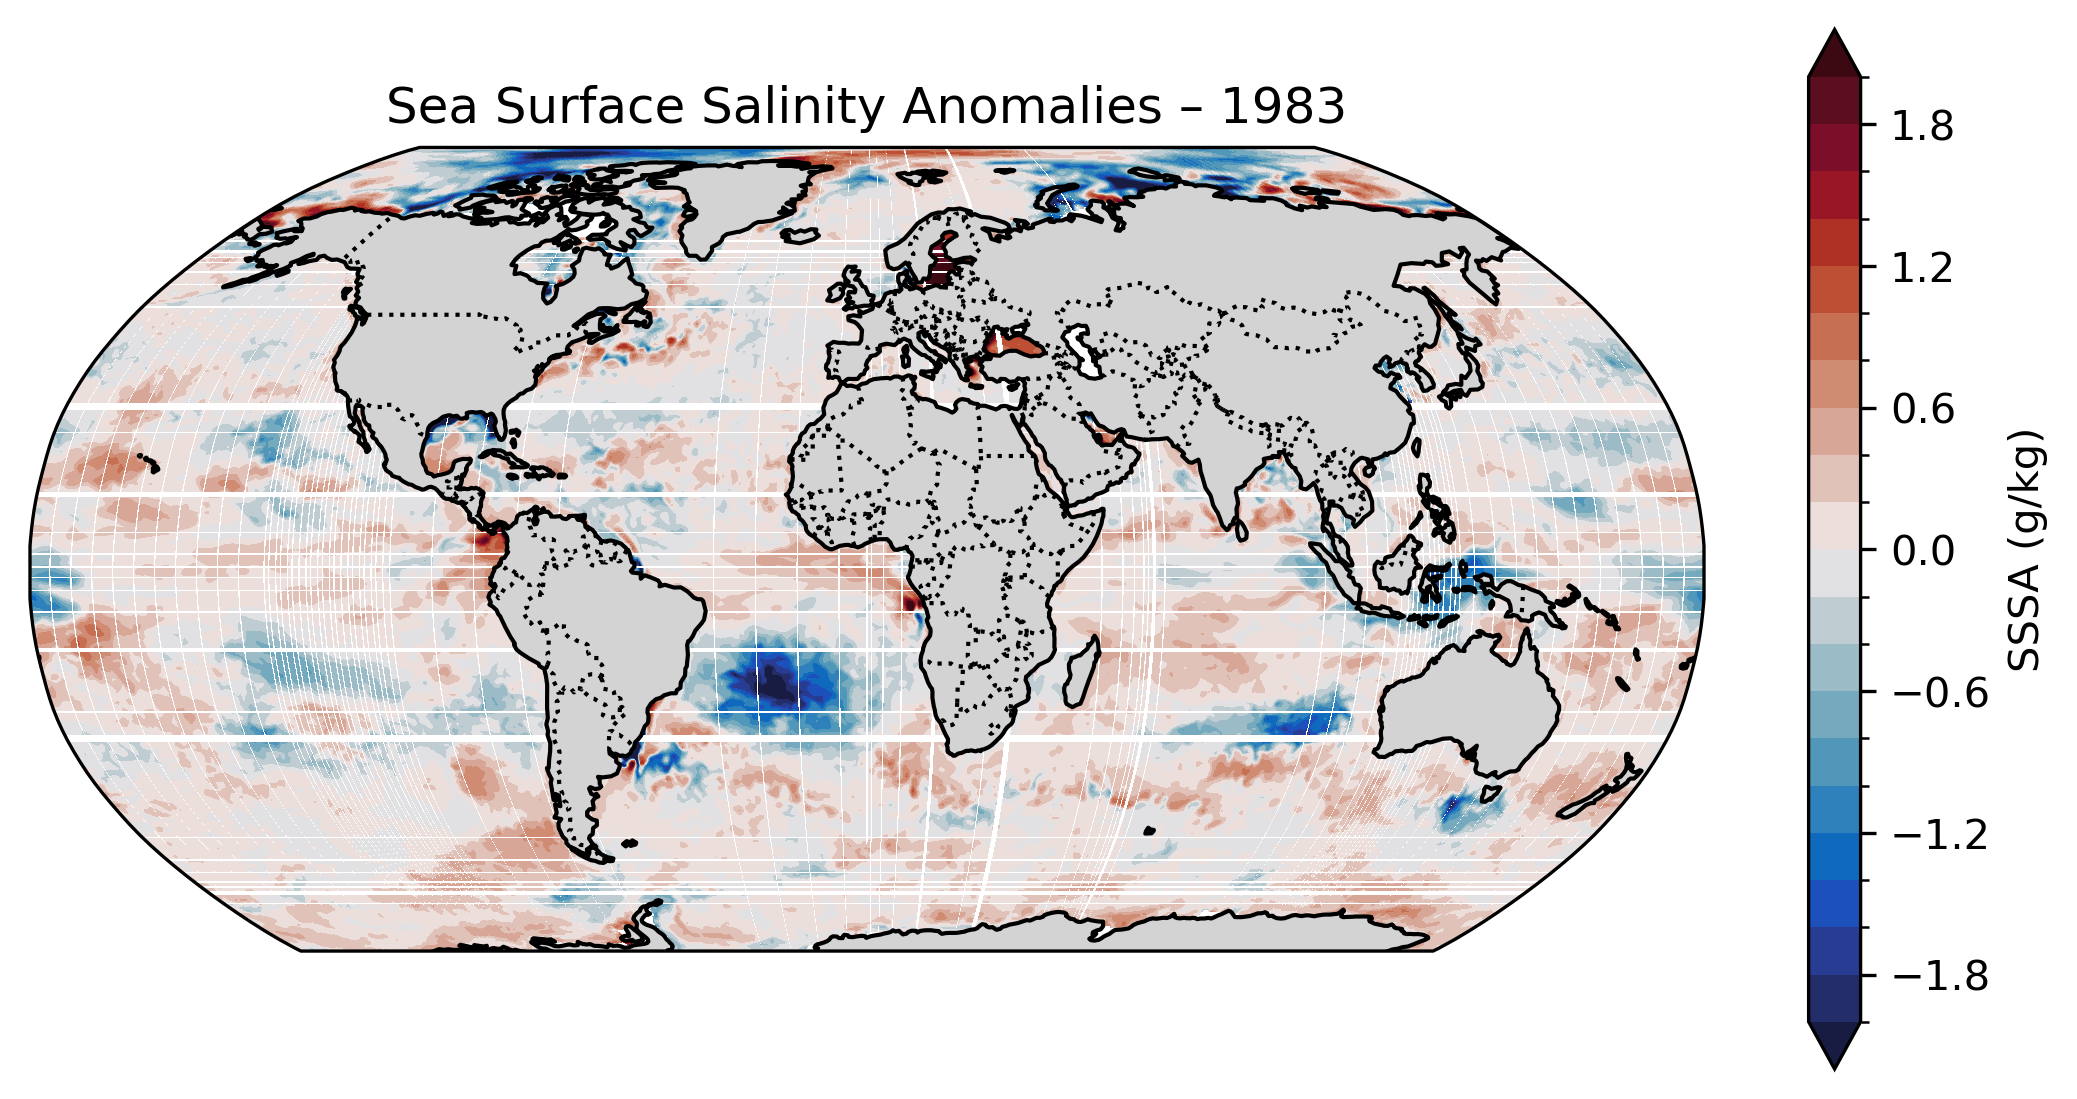

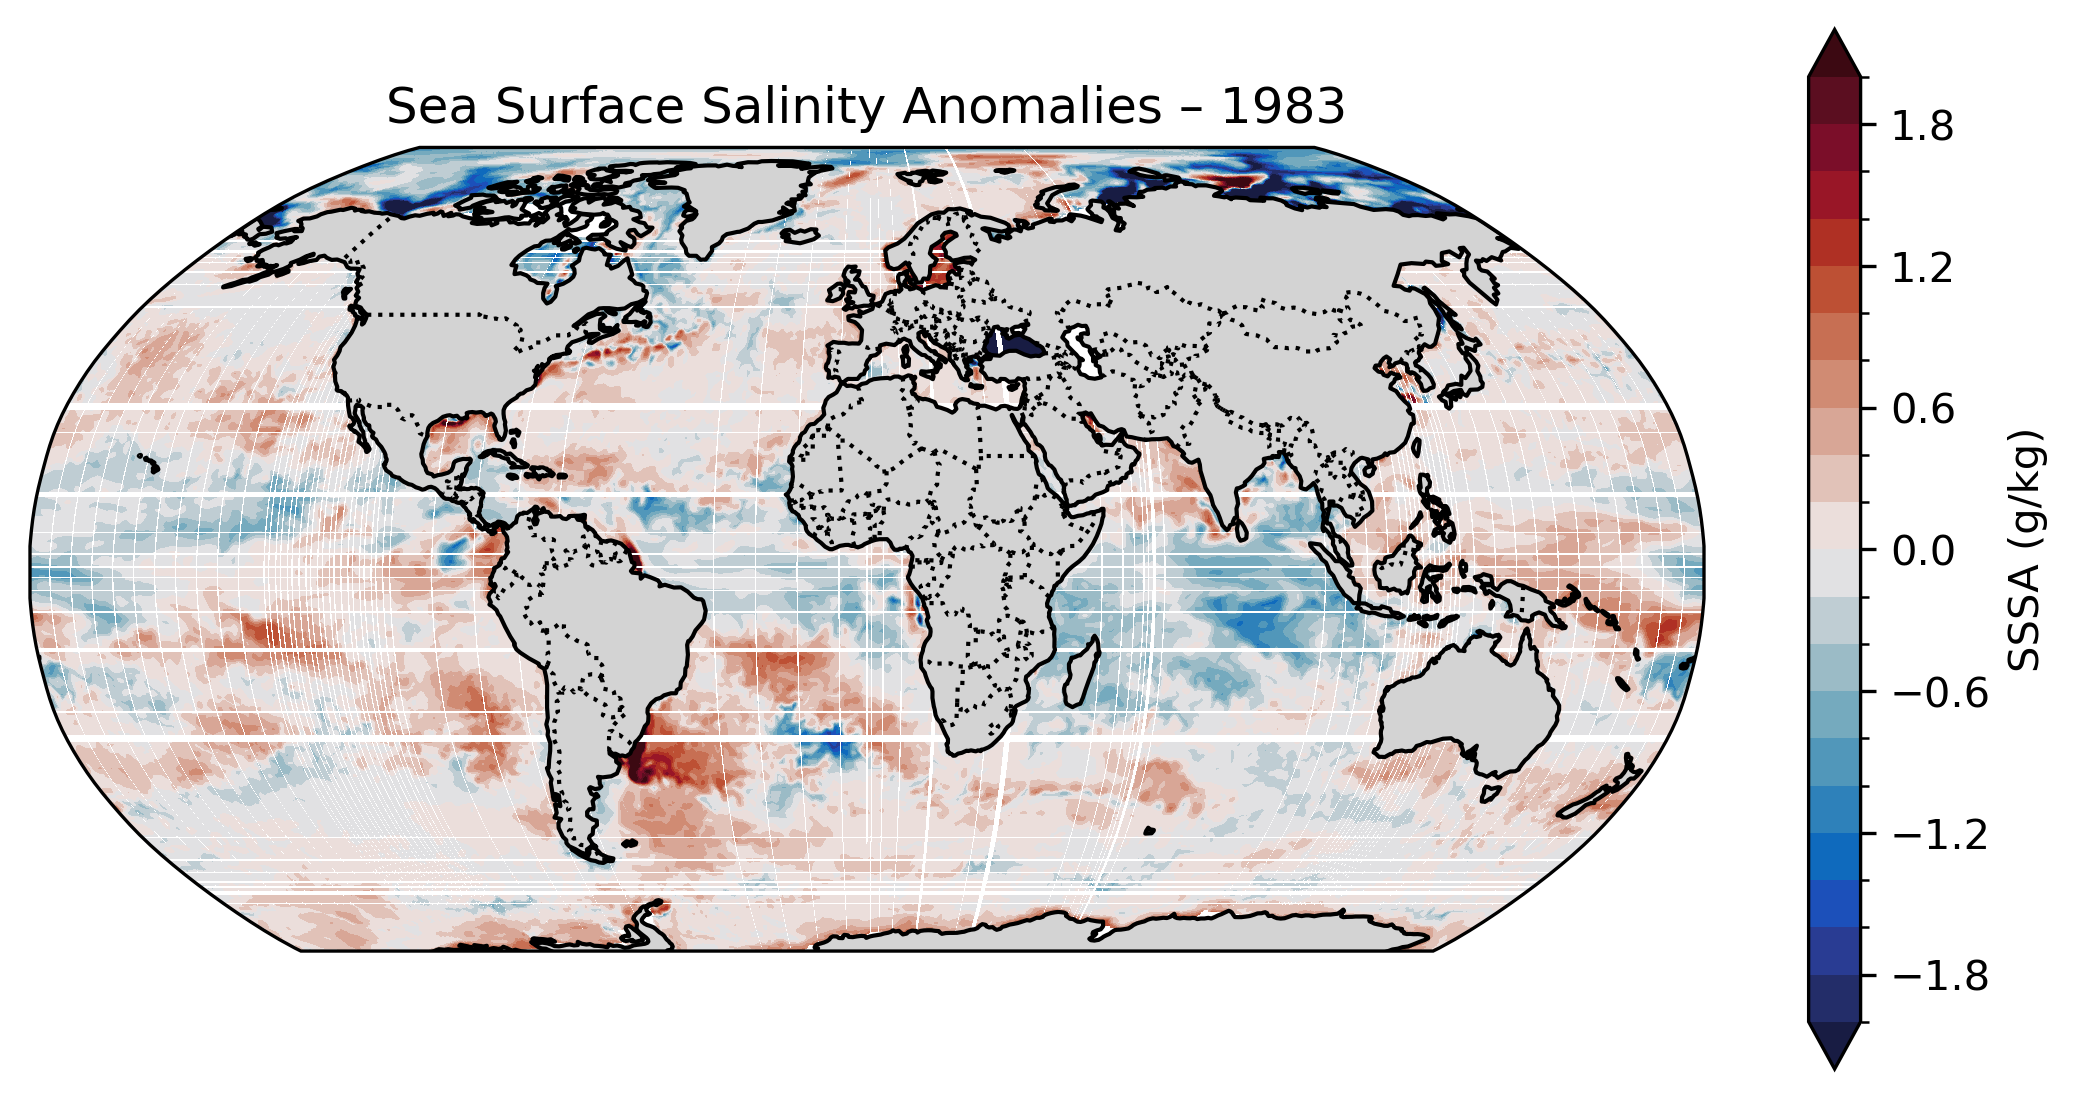

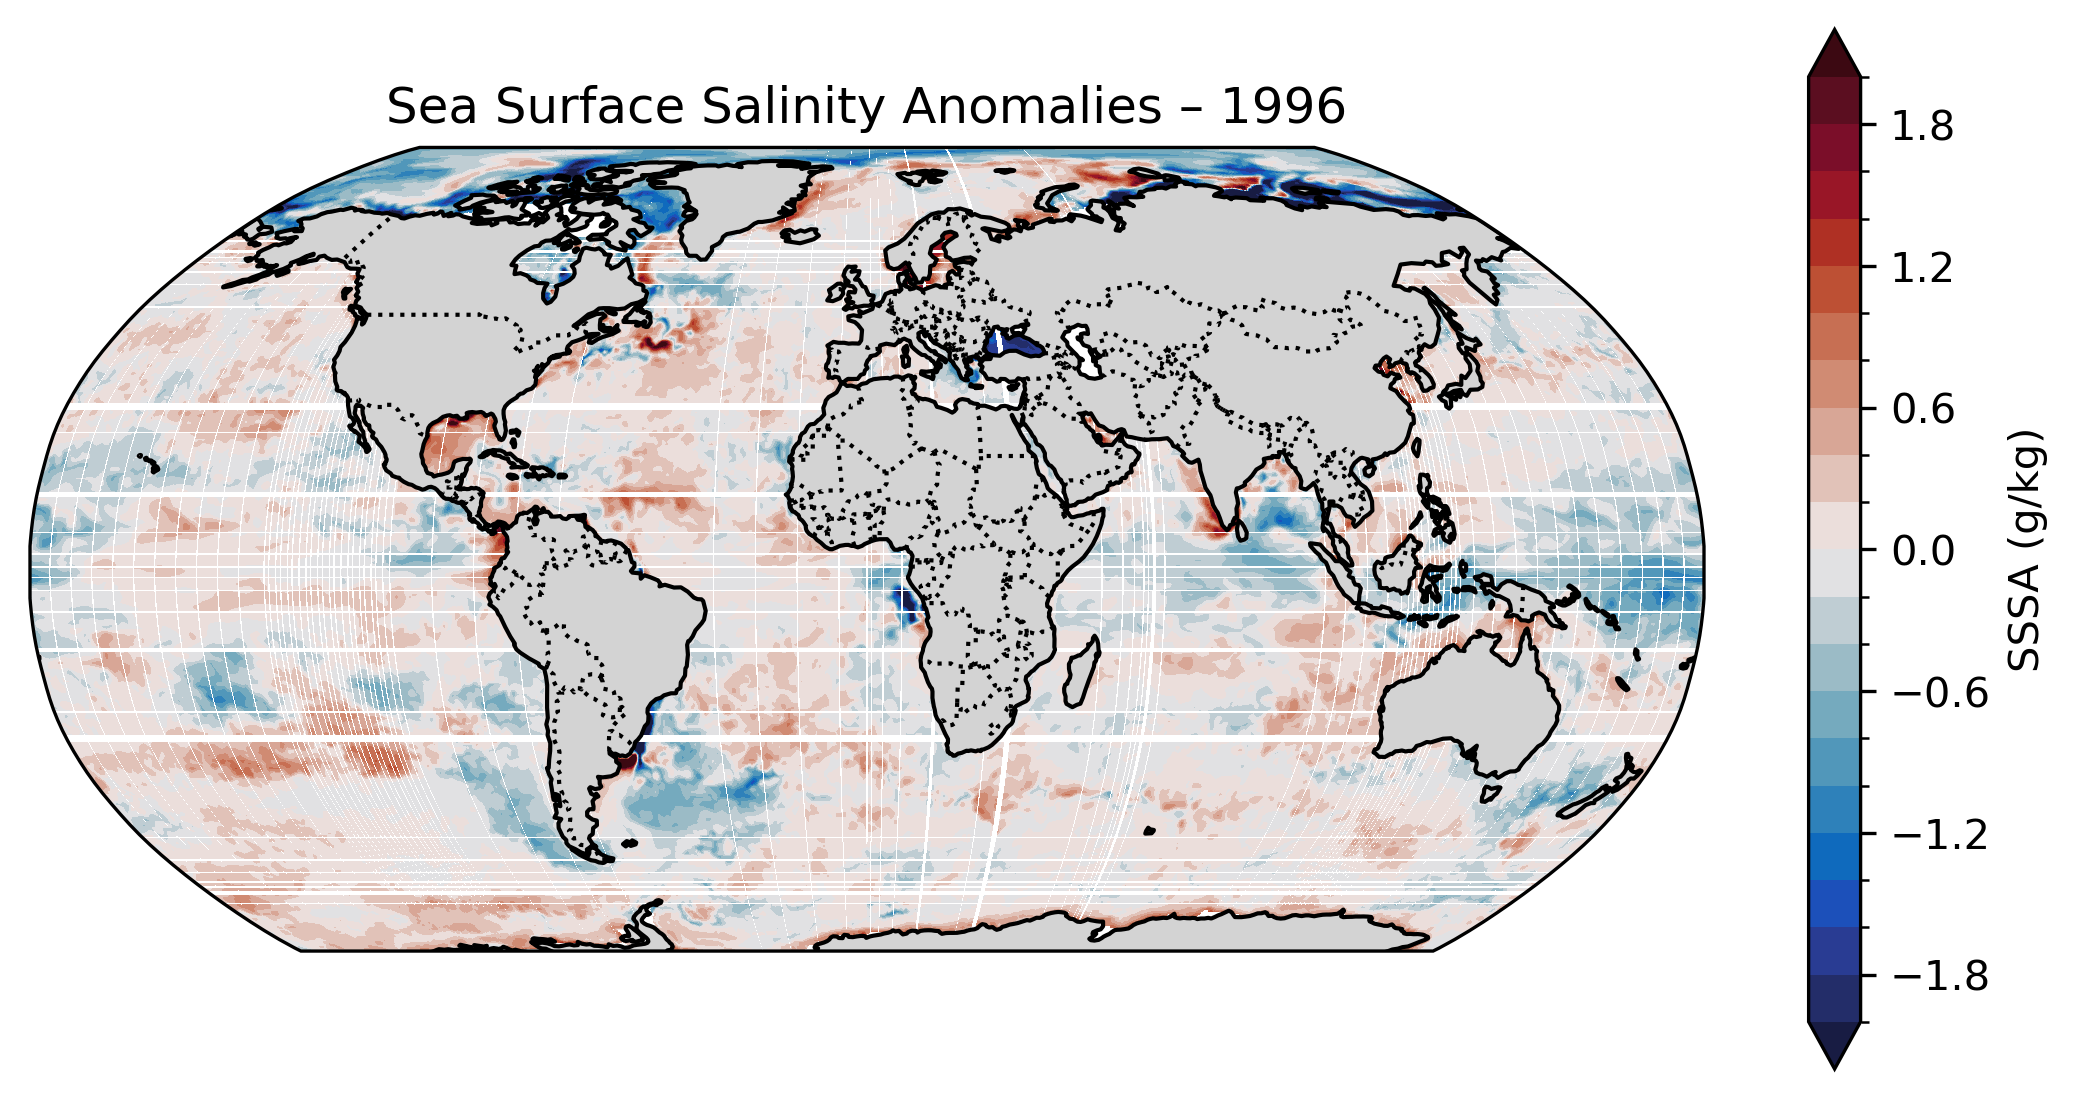

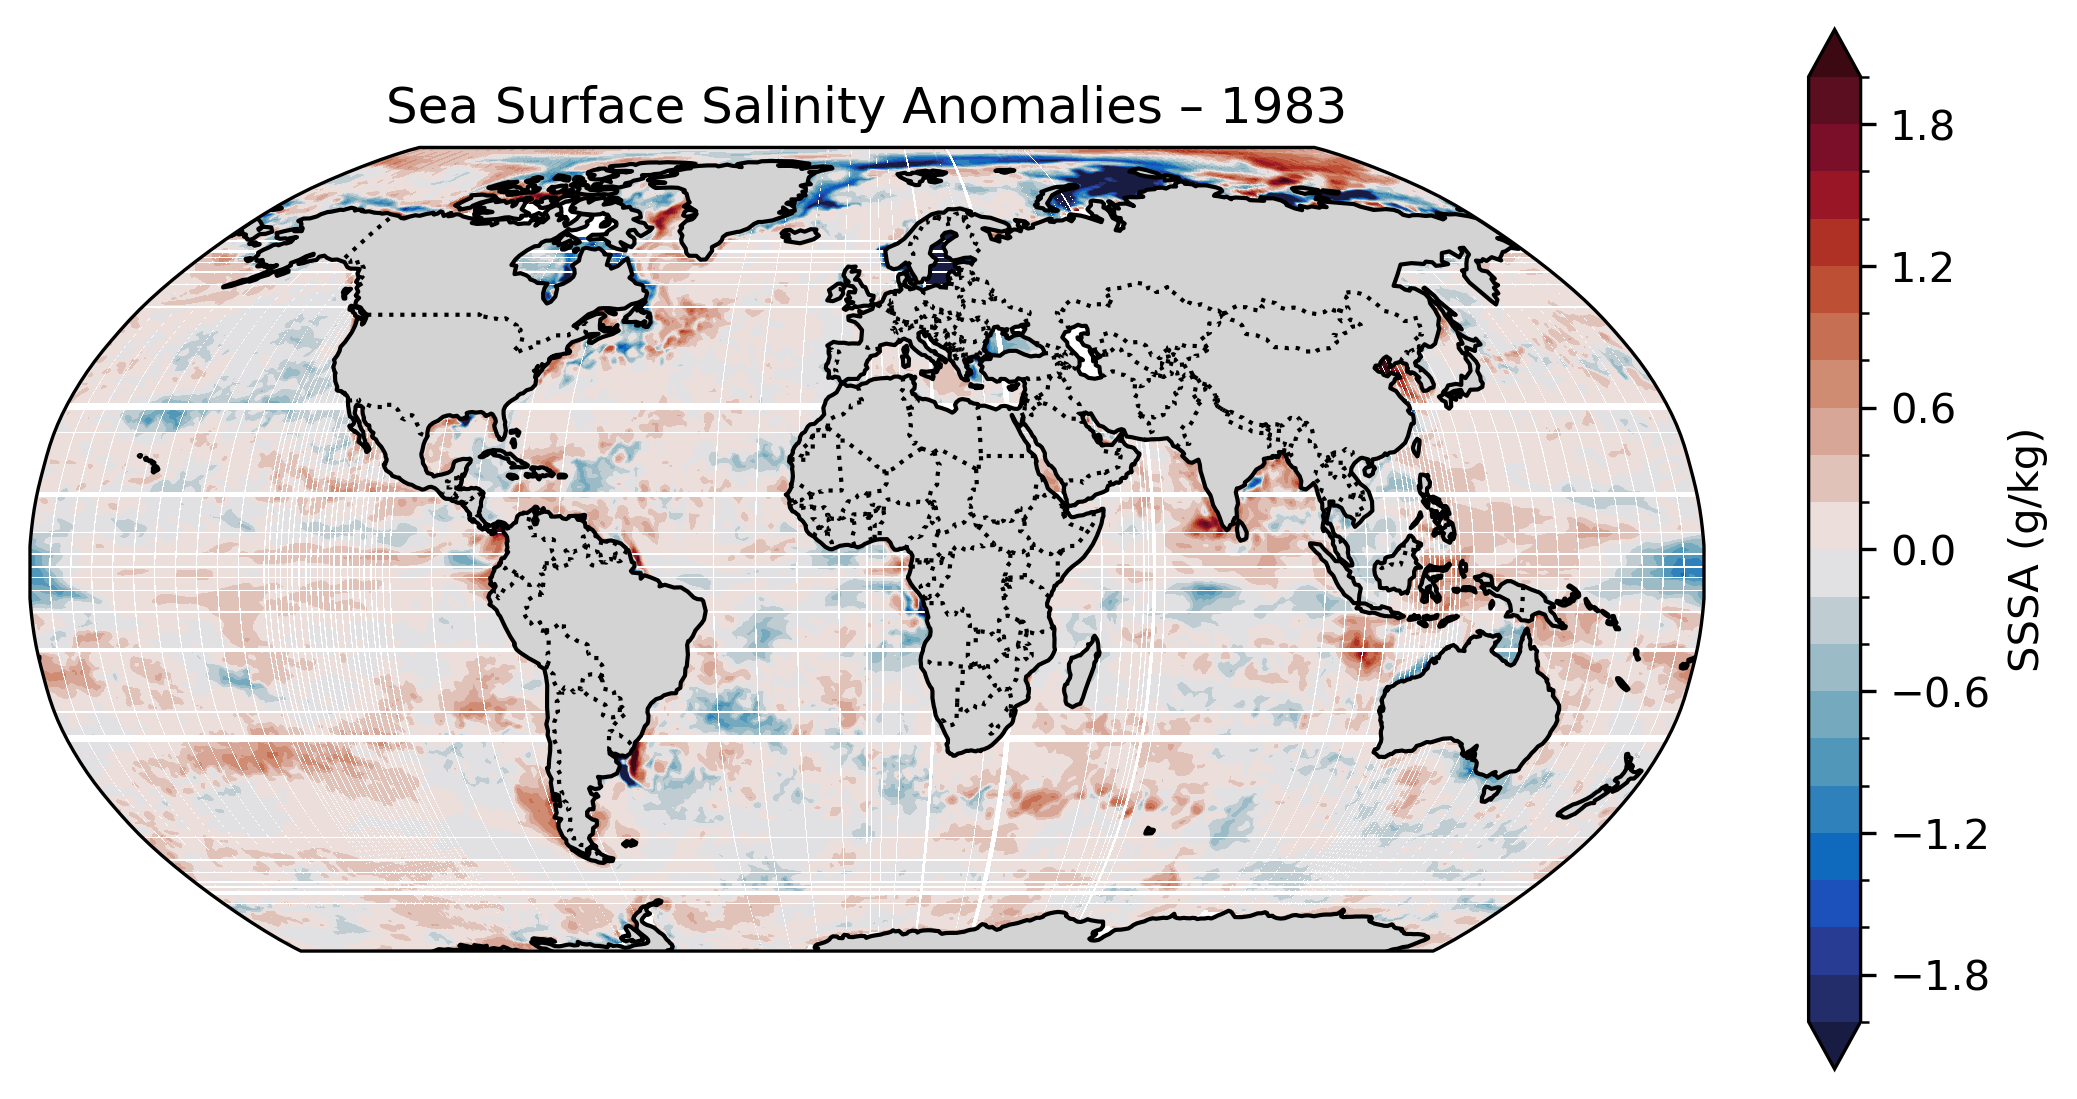

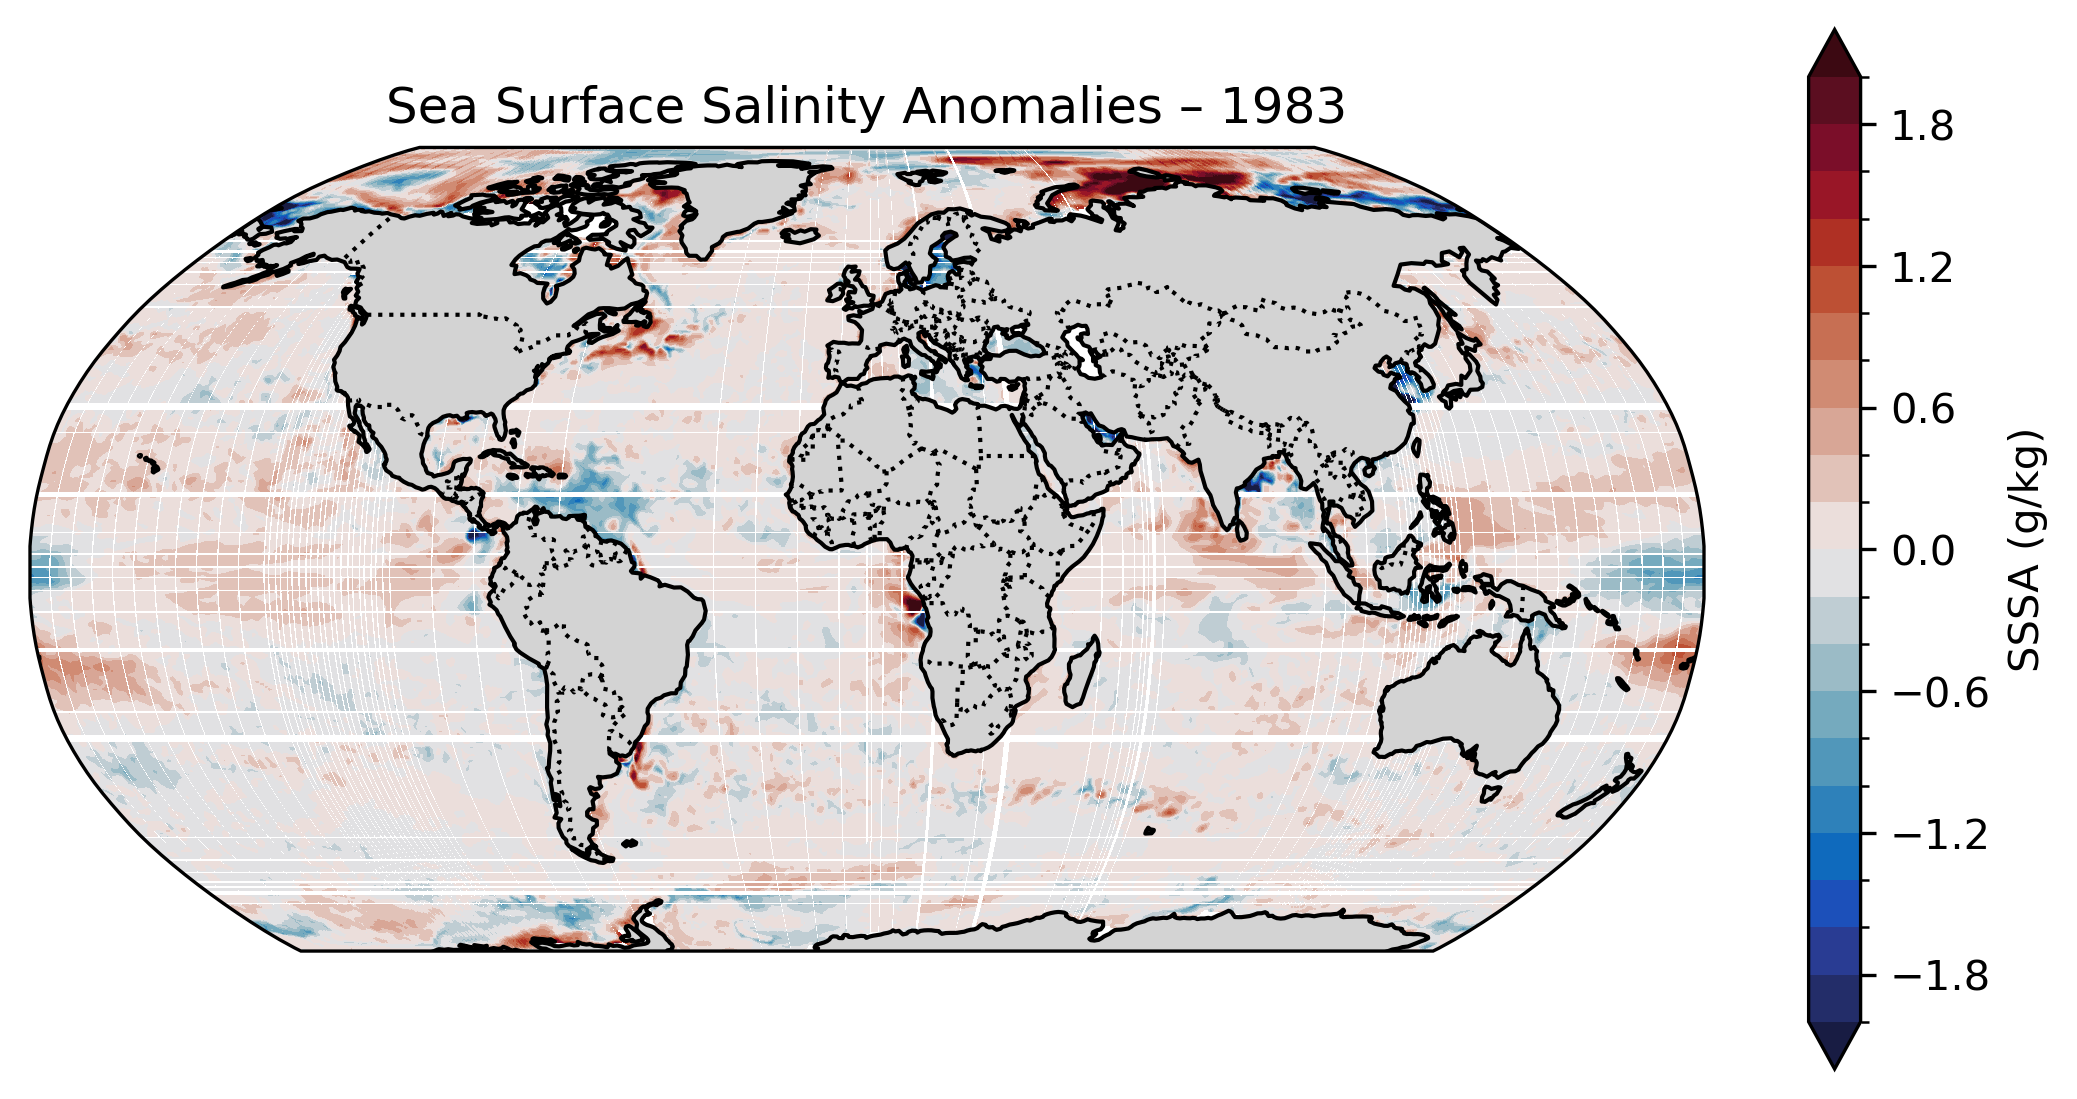

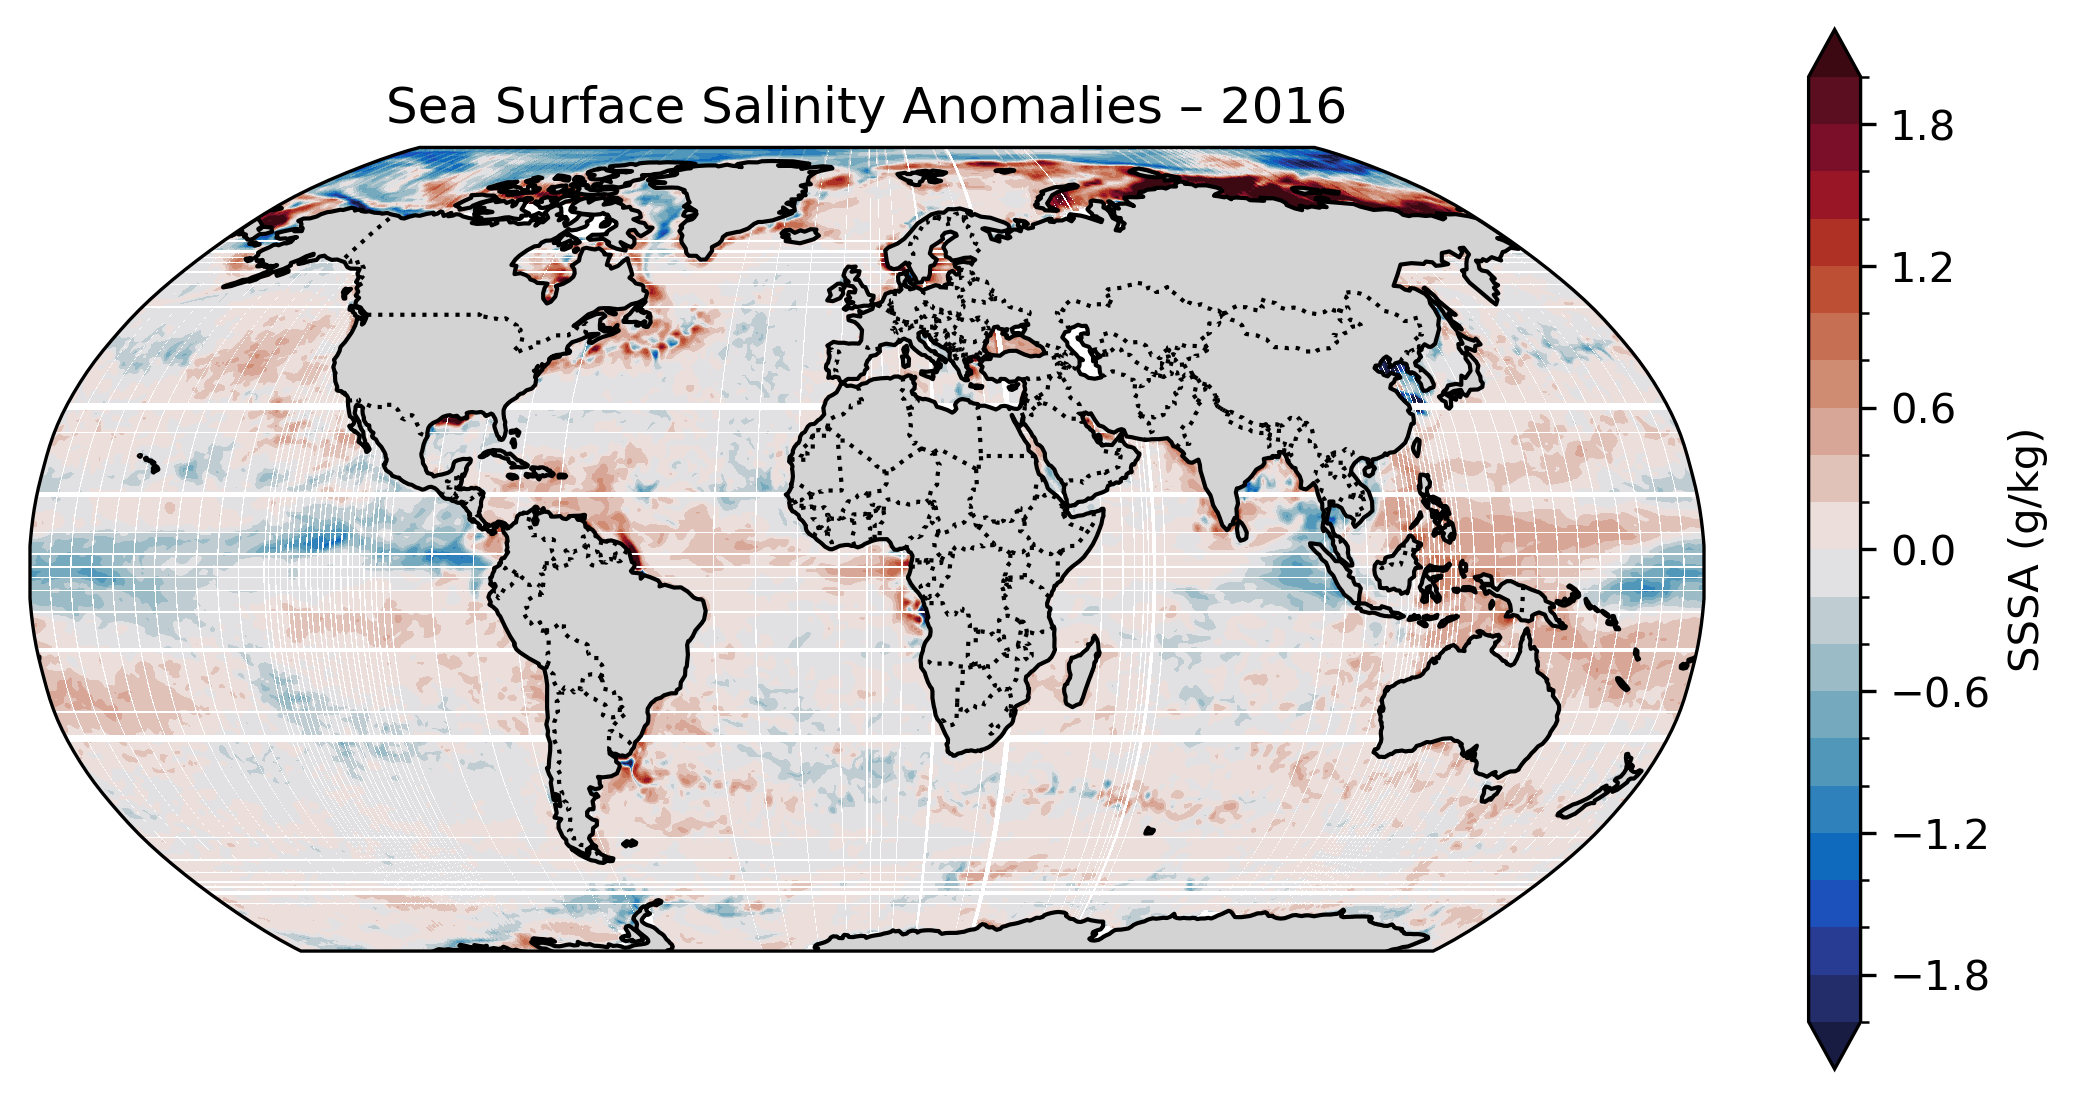

In [11]:
SSS_detrend = detrend(soda['salt'], 'time', deg=1)

SSS_filt = SSS_detrend 

# group a DataArray called 'sst' by month and calculate the average monthly values (i.e., the climatology)
sss_clim = SSS_filt.groupby(SSS_filt['time'].dt.month).mean()

monthly_sss = SSS_filt.groupby(SSS_filt['time'].dt.month)

sssa = monthly_sss - sss_clim

#anomaly time slice
sssa_1983 = sssa.sel(time=slice('1983-01-01T01:00:00.000000000', '1983-2-01T01:00:00.000000000'))
sssa_1987 = sssa.sel(time=slice('1987-01-01T01:00:00.000000000', '1987-2-01T01:00:00.000000000'))
sssa_1992 = sssa.sel(time=slice('1992-01-01T01:00:00.000000000', '1992-2-01T01:00:00.000000000'))
sssa_1995 = sssa.sel(time=slice('1995-01-01T01:00:00.000000000', '1995-2-01T01:00:00.000000000'))
sssa_1998 = sssa.sel(time=slice('1998-01-01T01:00:00.000000000', '1998-2-01T01:00:00.000000000'))
sssa_2003 = sssa.sel(time=slice('2003-01-01T01:00:00.000000000', '2003-2-01T01:00:00.000000000'))
sssa_2010 = sssa.sel(time=slice('2010-01-01T01:00:00.000000000', '2010-2-01T01:00:00.000000000'))
sssa_2016 = sssa.sel(time=slice('2016-01-01T01:00:00.000000000', '2016-2-01T01:00:00.000000000'))


def plot_sssa_time_slice(sssa_data, title, time_index=0):
    # Select the time slice
    sssa_slice = sssa_data.isel(time=time_index)
    
    # Create figure and map axis
    proj = ccrs.Robinson(central_longitude=0)
    cmap = cmocean.cm.balance
    lev = np.arange(-2, 2.2, 0.2)

    fig = plt.figure(figsize=(9, 4.5), dpi=300)
    ax = plt.axes(projection = proj)
    
    # Plot filled contours
    sssa_slice.plot.contourf(
        x='xt_ocean',
        y='yt_ocean',
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=lev,
        extend='both',
        cmap=cmap,
        add_colorbar=True,
        cbar_kwargs={'label': 'SSSA (g/kg)'}
    )
    
    # Add land and borders
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='lightgray'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(title)
    plt.show()
    title = f"A_{str(i)}_SSSA"
    fig.savefig(f'_{title}.png', facecolor='white', transparent=False, bbox_inches='tight')

# Plot all three datasets for their first time slice (index 0)
plot_sssa_time_slice(sssa_1983, 'Sea Surface Salinity Anomalies – 1983', time_index=0)
plot_sssa_time_slice(sssa_1987, 'Sea Surface Salinity Anomalies – 1983', time_index=0)
plot_sssa_time_slice(sssa_1992, 'Sea Surface Salinity Anomalies – 1983', time_index=0)
plot_sssa_time_slice(sssa_1995, 'Sea Surface Salinity Anomalies – 1996', time_index=0)
plot_sssa_time_slice(sssa_2003, 'Sea Surface Salinity Anomalies – 1983', time_index=0)
plot_sssa_time_slice(sssa_2010, 'Sea Surface Salinity Anomalies – 1983', time_index=0)
plot_sssa_time_slice(sssa_2016, 'Sea Surface Salinity Anomalies – 2016', time_index=0)


In [12]:
#jan el nino average
sssa_1983_mean=sssa_1983.mean(dim=['time', 'yt_ocean'])
sssa_1987_mean=sssa_1987.mean(dim=['time', 'yt_ocean'])
sssa_1992_mean=sssa_1992.mean(dim=['time', 'yt_ocean'])
sssa_1995_mean=sssa_1995.mean(dim=['time', 'yt_ocean'])
sssa_2003_mean=sssa_2003.mean(dim=['time', 'yt_ocean'])
sssa_2010_mean=sssa_2010.mean(dim=['time', 'yt_ocean'])
sssa_2016_mean=sssa_2016.mean(dim=['time', 'yt_ocean'])

In [30]:
sssa_2014 = sssa.sel(time=slice('2014-01-01T01:00:00.000000000', '2015-2-01T01:00:00.000000000'))
sssa_1995 = sssa.sel(time=slice('1995-01-01T01:00:00.000000000', '1996-2-01T01:00:00.000000000'))
sssa_2014_mean=sssa_2014.mean(dim=['time', 'yt_ocean'])
sssa_1995_mean=sssa_1995.mean(dim=['time', 'yt_ocean'])

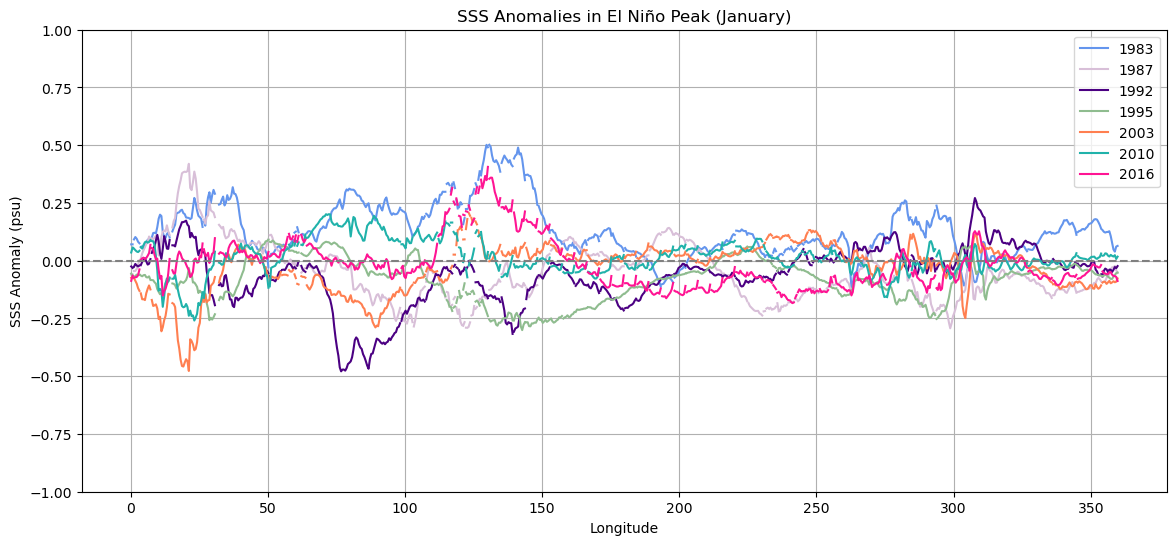

In [37]:
#SSS Anomalies in El Niño Peak (January)

plt.figure(figsize=(14, 6))

plt.plot(sssa_1983_mean.xt_ocean, sssa_1983_mean, label='1983', color='cornflowerblue')
plt.plot(sssa_1987_mean.xt_ocean, sssa_1987_mean, label='1987', color='thistle')
plt.plot(sssa_1992_mean.xt_ocean, sssa_1992_mean, label='1992', color='indigo')
plt.plot(sssa_1995_mean.xt_ocean, sssa_1995_mean, label='1995', color='darkseagreen')
plt.plot(sssa_2003_mean.xt_ocean, sssa_2003_mean, label='2003', color='coral')
plt.plot(sssa_2010_mean.xt_ocean, sssa_2010_mean, label='2010', color='lightseagreen')
plt.plot(sssa_2016_mean.xt_ocean, sssa_2016_mean, label='2016', color='deeppink')

plt.title("SSS Anomalies in El Niño Peak (January)")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()

plt.savefig('SSSAnomaliesinElNiñoPeak(January).png', bbox_inches='tight', dpi=300)

In [14]:
#may el niño subset
sssa_1983_may = sssa.sel(time=slice('1983-05-01T01:00:00.000000000', '1983-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1987_may = sssa.sel(time=slice('1987-05-01T01:00:00.000000000', '1987-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1992_may = sssa.sel(time=slice('1992-05-01T01:00:00.000000000', '1992-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1995_may = sssa.sel(time=slice('1995-05-01T01:00:00.000000000', '1995-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1998_may = sssa.sel(time=slice('1998-05-01T01:00:00.000000000', '1998-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_2003_may = sssa.sel(time=slice('2003-05-01T01:00:00.000000000', '2003-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_2010_may = sssa.sel(time=slice('2010-05-01T01:00:00.000000000', '2010-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_2016_may = sssa.sel(time=slice('2016-05-01T01:00:00.000000000', '2016-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])

In [15]:
#august el niño subset
sssa_1983_aug = sssa.sel(time=slice('1983-08-01T01:00:00.000000000', '1983-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1987_aug = sssa.sel(time=slice('1987-08-01T01:00:00.000000000', '1987-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1992_aug = sssa.sel(time=slice('1992-08-01T01:00:00.000000000', '1992-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1995_aug = sssa.sel(time=slice('1995-08-01T01:00:00.000000000', '1995-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1998_aug = sssa.sel(time=slice('1998-08-01T01:00:00.000000000', '1998-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_2003_aug = sssa.sel(time=slice('2003-08-01T01:00:00.000000000', '2003-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_2010_aug = sssa.sel(time=slice('2010-08-01T01:00:00.000000000', '2010-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_2016_aug = sssa.sel(time=slice('2016-08-01T01:00:00.000000000', '2016-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])


In [31]:
sssa_2014_may = sssa.sel(time=slice('2014-05-01T01:00:00.000000000', '2015-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1995_may = sssa.sel(time=slice('1995-05-01T01:00:00.000000000', '1996-6-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_2014_aug = sssa.sel(time=slice('2014-08-01T01:00:00.000000000', '2015-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])
sssa_1995_aug = sssa.sel(time=slice('1995-08-01T01:00:00.000000000', '1996-9-01T01:00:00.000000000')).mean(dim=['time','yt_ocean'])

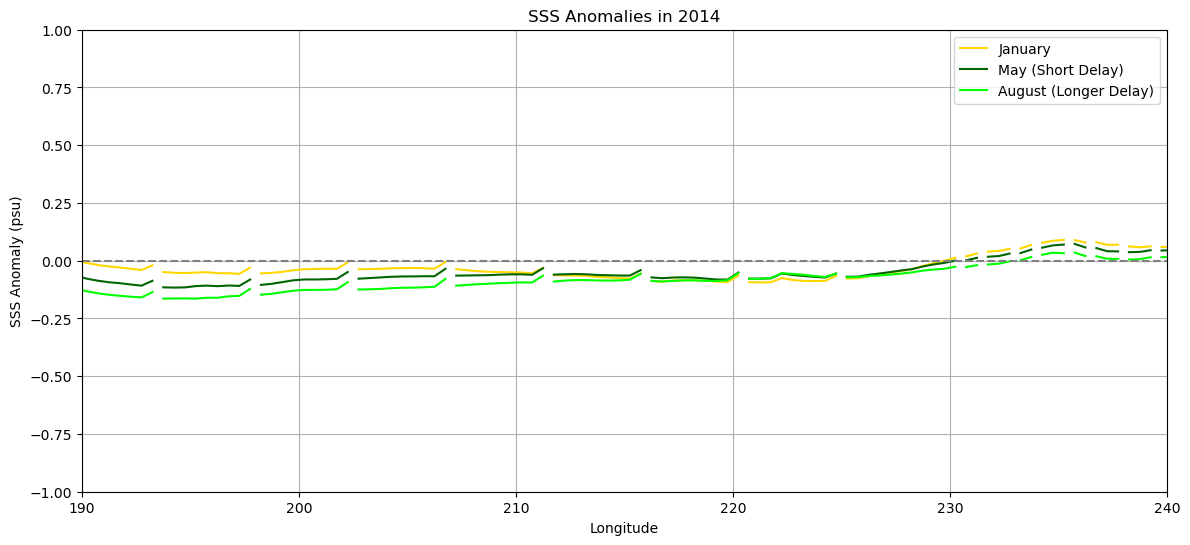

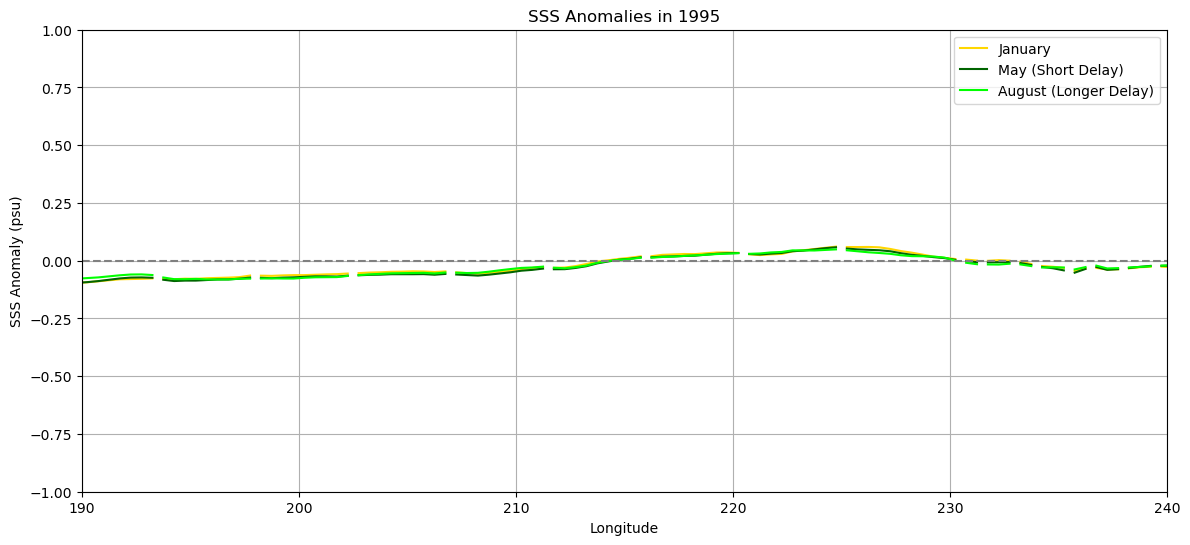

In [35]:
#time lag lon line plot 
#2014 NON ENSO
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_2014_mean.xt_ocean, sssa_2014_mean, label='January', color='gold')
plt.plot(sssa_2014_may.xt_ocean, sssa_2014_may, label='May (Short Delay)', color='darkgreen')
plt.plot(sssa_2014_aug.xt_ocean, sssa_2014_aug, label='August (Longer Delay)', color='lime')
    
plt.title("SSS Anomalies in 2014")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('2014_nonNino.png', bbox_inches='tight', dpi=300)

#1995 NON ENSO
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_1995_mean.xt_ocean, sssa_1995_mean, label='January', color='gold')
plt.plot(sssa_1995_may.xt_ocean, sssa_1995_may, label='May (Short Delay)', color='darkgreen')
plt.plot(sssa_1995_aug.xt_ocean, sssa_1995_aug, label='August (Longer Delay)', color='lime')
    
plt.title("SSS Anomalies in 1995")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('1995_nonNino.png', bbox_inches='tight', dpi=300)


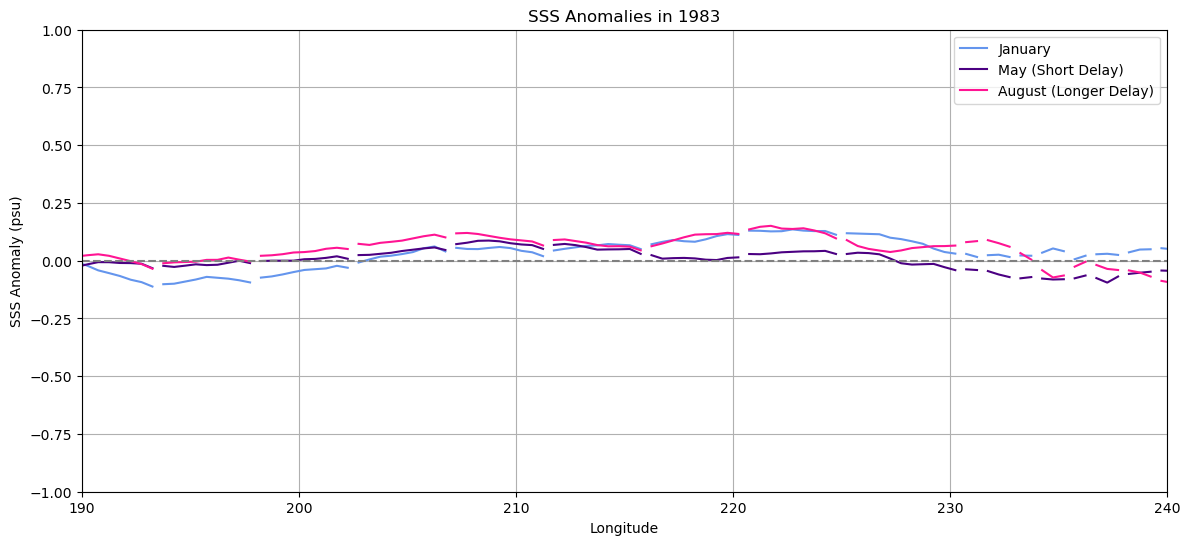

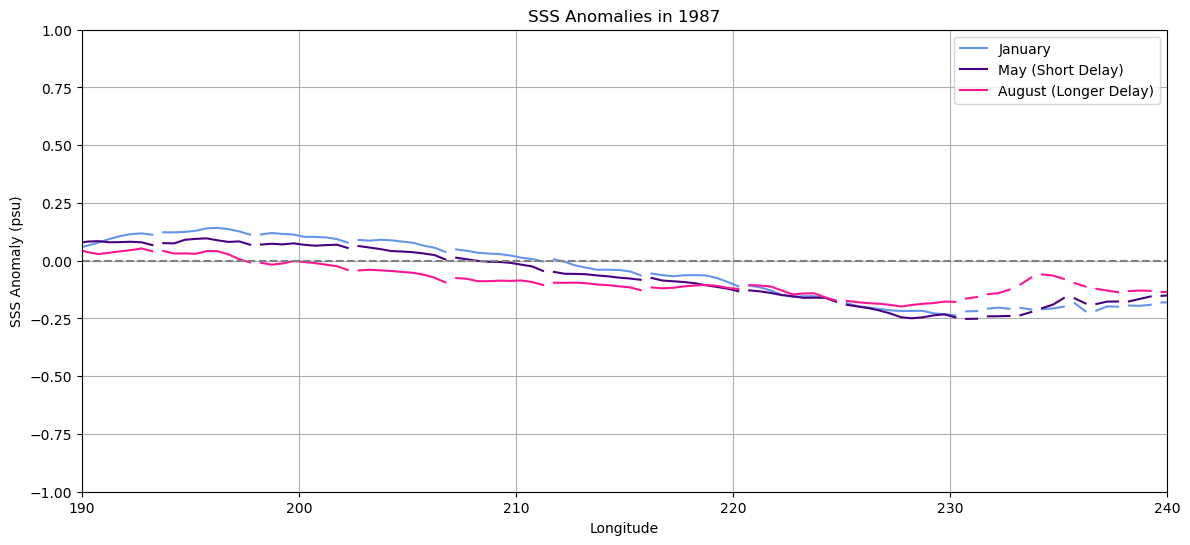

In [36]:
#time lag lon line plot 
#1983
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_1983_mean.xt_ocean, sssa_1983_mean, label='January', color='cornflowerblue')
plt.plot(sssa_1983_may.xt_ocean, sssa_1983_may, label='May (Short Delay)', color='indigo')
plt.plot(sssa_1983_aug.xt_ocean, sssa_1983_aug, label='August (Longer Delay)', color='deeppink')
    
plt.title("SSS Anomalies in 1983")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('1983_Nino.png', bbox_inches='tight', dpi=300)

#1987
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_1987_mean.xt_ocean, sssa_1987_mean, label='January', color='cornflowerblue')
plt.plot(sssa_1987_may.xt_ocean, sssa_1987_may, label='May (Short Delay)', color='indigo')
plt.plot(sssa_1987_aug.xt_ocean, sssa_1987_aug, label='August (Longer Delay)', color='deeppink')
    
plt.title("SSS Anomalies in 1987")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('1987_Nino.png', bbox_inches='tight', dpi=300)


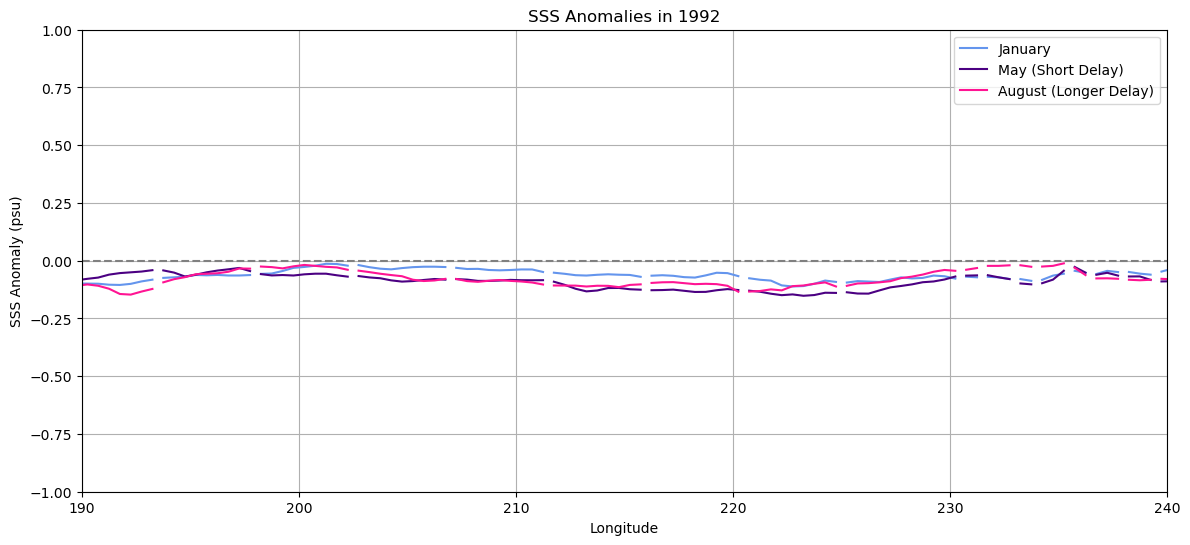

In [25]:
#1992
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_1992_mean.xt_ocean, sssa_1992_mean, label='January', color='cornflowerblue')
plt.plot(sssa_1992_may.xt_ocean, sssa_1992_may, label='May (Short Delay)', color='indigo')
plt.plot(sssa_1992_aug.xt_ocean, sssa_1992_aug, label='August (Longer Delay)', color='deeppink')
    
plt.title("SSS Anomalies in 1992")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('1992_Nino.png', bbox_inches='tight', dpi=300)


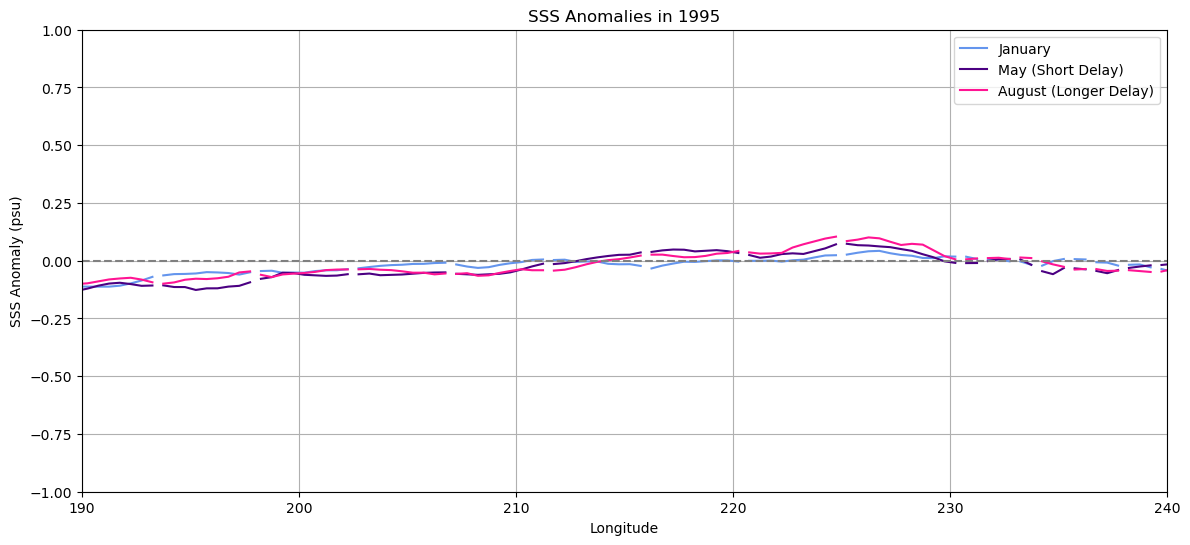

In [26]:
#1995
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_1995_mean.xt_ocean, sssa_1995_mean, label='January', color='cornflowerblue')
plt.plot(sssa_1995_may.xt_ocean, sssa_1995_may, label='May (Short Delay)', color='indigo')
plt.plot(sssa_1995_aug.xt_ocean, sssa_1995_aug, label='August (Longer Delay)', color='deeppink')
    
plt.title("SSS Anomalies in 1995")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('1995_Nino.png', bbox_inches='tight', dpi=300)


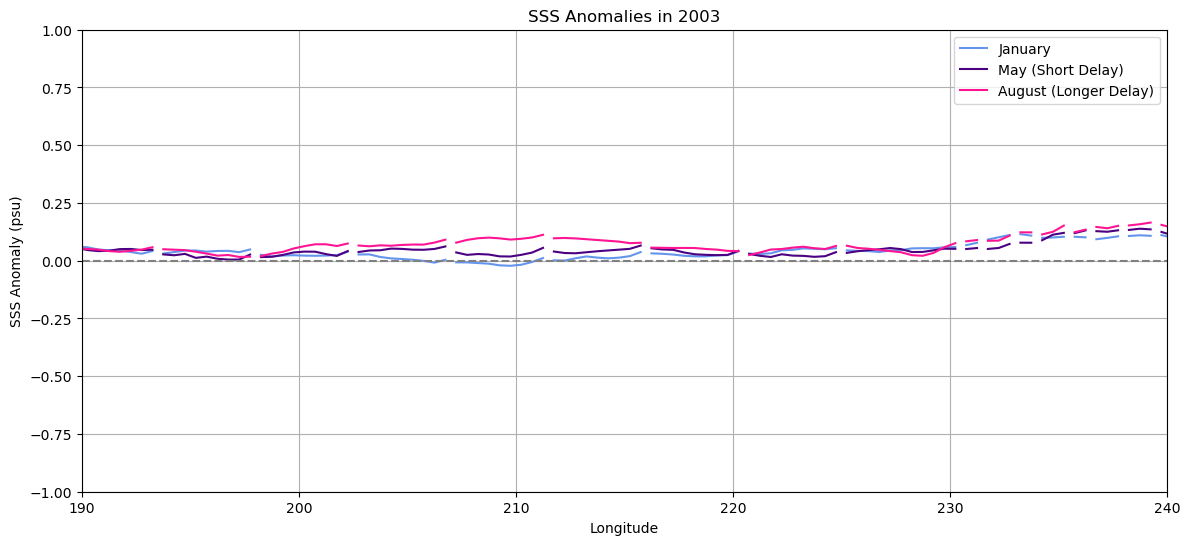

In [27]:
#2003
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_2003_mean.xt_ocean, sssa_2003_mean, label='January', color='cornflowerblue')
plt.plot(sssa_2003_may.xt_ocean, sssa_2003_may, label='May (Short Delay)', color='indigo')
plt.plot(sssa_2003_aug.xt_ocean, sssa_2003_aug, label='August (Longer Delay)', color='deeppink')
    
plt.title("SSS Anomalies in 2003")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('2003_Nino.png', bbox_inches='tight', dpi=300)

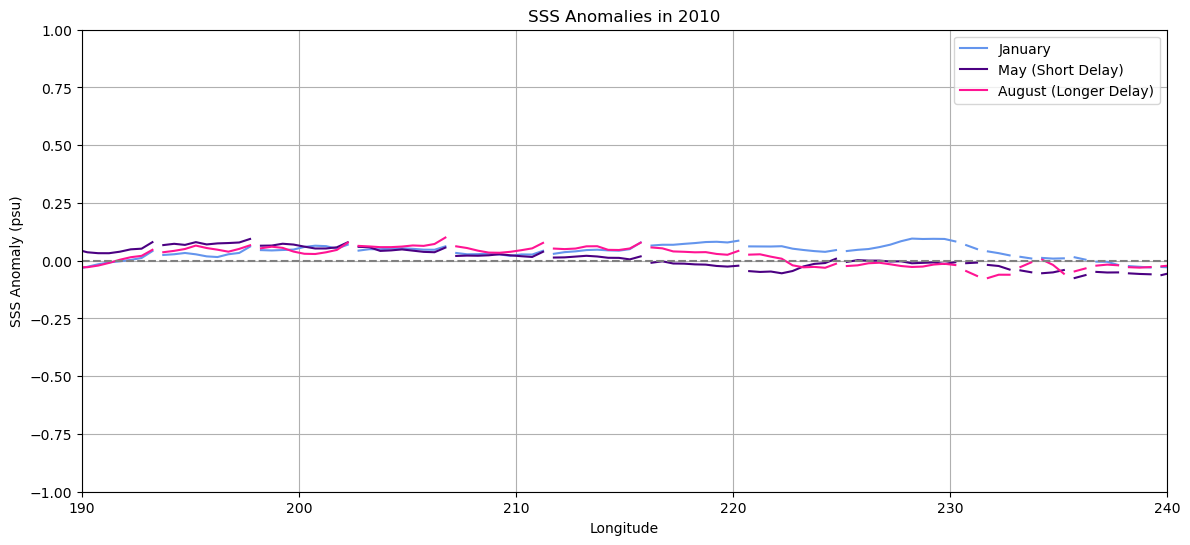

In [28]:
#2010
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_2010_mean.xt_ocean, sssa_2010_mean, label='January', color='cornflowerblue')
plt.plot(sssa_2010_may.xt_ocean, sssa_2010_may, label='May (Short Delay)', color='indigo')
plt.plot(sssa_2010_aug.xt_ocean, sssa_2010_aug, label='August (Longer Delay)', color='deeppink')
    
plt.title("SSS Anomalies in 2010")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('2010_Nino.png', bbox_inches='tight', dpi=300)

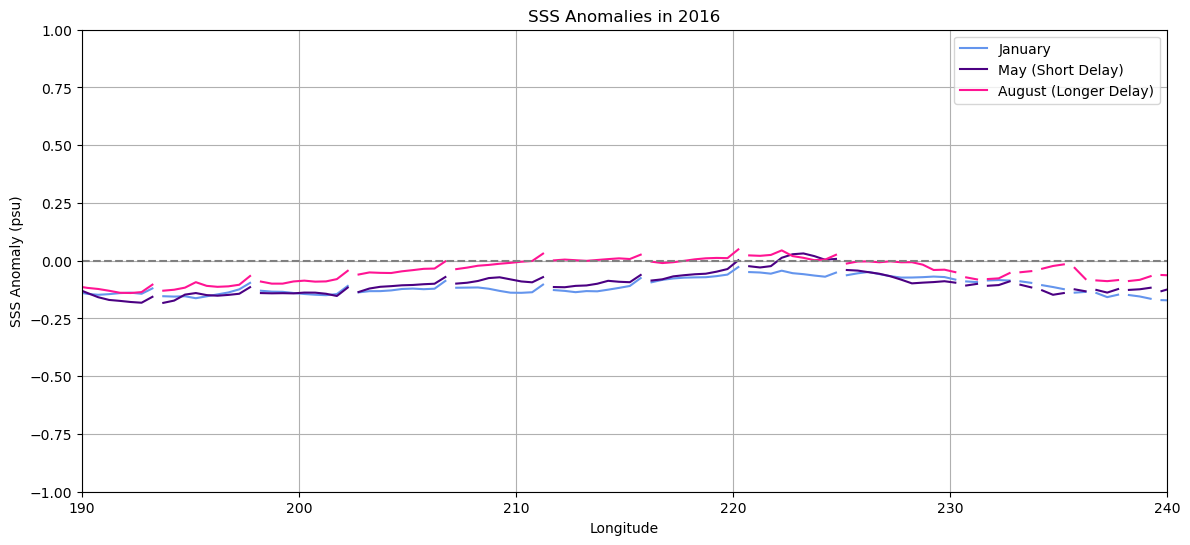

In [29]:
#2016
plt.figure(figsize=(14, 6))
    
plt.plot(sssa_2016_mean.xt_ocean, sssa_2016_mean, label='January', color='cornflowerblue')
plt.plot(sssa_2016_may.xt_ocean, sssa_2016_may, label='May (Short Delay)', color='indigo')
plt.plot(sssa_2016_aug.xt_ocean, sssa_2016_aug, label='August (Longer Delay)', color='deeppink')
    
plt.title("SSS Anomalies in 2016")
plt.xlabel('Longitude')
plt.ylabel('SSS Anomaly (psu)')
plt.ylim(-1, 1)
plt.xlim(190, 240)
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid()
    
plt.savefig('2016_Nino.png', bbox_inches='tight', dpi=300)
